# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
sciper = {'student_1': 233984, 
          'student_2': 285467}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

# Custom imports
import pickle
import time

Using TensorFlow backend.


In [2]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None, H_only=False):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))

    xlim = [-1,np.where(P==1)[0][-1]+1]
        
    if H_only == False:

        activeidxes = np.where(np.sum(P, axis=0)>0.)[0]
        plt.figure(figsize=(8,4))
        if PrP is not None:
            targets = np.where(P[:,activeidxes]==1)
            plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
            plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
        else:
            plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.ylim([-0.5,len(activeidxes)-0.5])
        plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$P[n]$")
        plt.xlim(xlim)
        plt.show()

        activeidxes = np.where(np.sum(T, axis=0)>0.)[0]
        plt.figure(figsize=(8,4))
        if PrT is not None:
            targets = np.where(T[:,activeidxes]==1)
            plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
            plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
        else:
            plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.ylim([-0.5,len(activeidxes)-0.5])
        plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$T[n]$")
        plt.xlim(xlim)
        plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.colorbar()
        plt.show()


def plotLearningCurves(log):
    
#    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Downsample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T": [], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4604/45853 melodies retained


### Solution

In [4]:
dataset_length = len(list(dataset.keys()))
i = 0

def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        if event.name in ['Note On', 'Note Off']:
            if event.name == 'Note Off': #ignore delay ticks?
                if event.tick != 0:
                    P.append(event.data[0])
                    T.append(event.tick)
    return P, T

for label in list(dataset.keys()):
    i = i + 1
    if i % 500 == 0:
        print('parsed', i, ' out of ', dataset_length)
    Pseq, Tseq = parseMIDI(datapath + label + ".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq
print('\n')

for label in np.random.choice(list(dataset.keys()), 2, replace=False):
    print(label)
    print("MIDI events")
    display(datapath + label + ".mid")
    print("Note representation")
    print('Pitch:    {} ...\nDuration: {} ...'.format(dataset[label]['P'][:10], dataset[label]['T'][:10]))
    print('\n')


parsed 500  out of  4604
parsed 1000  out of  4604
parsed 1500  out of  4604
parsed 2000  out of  4604
parsed 2500  out of  4604
parsed 3000  out of  4604
parsed 3500  out of  4604
parsed 4000  out of  4604
parsed 4500  out of  4604


sessiontune34297
MIDI events
chorpus/sessiontune34297.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 73 	 Note On 	 105
240 	 73 	 Note Off 	 0
241 	 77 	 Note On 	 105
560 	 77 	 Note Off 	 0
561 	 73 	 Note On 	 80
720 	 73 	 Note Off 	 0
721 	 68 	 Note On 	 80
1200 	 68 	 Note Off 	 0
1201 	 65 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
31921 	 75 	 Note On 	 105
32400 	 75 	 Note Off 	 0
32401 	 73 	 Note On 	 80
32880 	 73 	 Note Off 	 0
32881 	 73 	 Note On 	 80
33200 	 73 	 Note Off 	 0
33201 	 75 	 Note On 	 80
33360 	 75 	 Note Off 	 0
########################################

Note representation
Pitch:    [73, 77, 73, 68, 65, 61, 65, 70, 73, 72] ..

In [5]:
#sanity check: length of P and T have to be the same
for label in np.random.choice(list(dataset.keys()), 2, replace=False):
    print(len(dataset[label]['P']), len(dataset[label]['T'])) #both P and T have same length

1002 1002
112 112


## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

1\. Gather unique pitches and durations.

In [6]:
set_P, set_T = set(), set() #use set datastructure to find distinct elements

for key in dataset.keys():
    set_P = set_P.union(set(dataset[key]['P']))
    set_T = set_T.union(set(dataset[key]['T']))
    
P = sorted(list(set_P))
T = sorted(list(set_T))

print('P: (value, index)\n', list(zip(P, range(len(P)))))
print('\nT: (value, index)\n', list(zip(T, range(len(T)))))

P: (value, index)
 [(48, 0), (49, 1), (50, 2), (51, 3), (52, 4), (53, 5), (54, 6), (55, 7), (56, 8), (57, 9), (58, 10), (59, 11), (60, 12), (61, 13), (62, 14), (63, 15), (64, 16), (65, 17), (66, 18), (67, 19), (68, 20), (69, 21), (70, 22), (71, 23), (72, 24), (73, 25), (74, 26), (75, 27), (76, 28), (77, 29), (78, 30), (79, 31), (80, 32), (81, 33), (82, 34), (83, 35), (84, 36), (85, 37), (86, 38), (87, 39), (88, 40), (89, 41), (90, 42), (91, 43), (92, 44), (93, 45), (94, 46)]

T: (value, index)
 [(10, 0), (29, 1), (39, 2), (49, 3), (59, 4), (79, 5), (89, 6), (95, 7), (105, 8), (109, 9), (117, 10), (119, 11), (149, 12), (159, 13), (160, 14), (179, 15), (199, 16), (202, 17), (209, 18), (212, 19), (219, 20), (229, 21), (230, 22), (239, 23), (250, 24), (279, 25), (299, 26), (309, 27), (319, 28), (349, 29), (359, 30), (399, 31), (419, 32), (459, 33), (469, 34), (479, 35), (480, 36), (559, 37), (599, 38), (639, 39), (692, 40), (699, 41), (709, 42), (719, 43), (799, 44), (839, 45), (929, 46), 

2\. Translate the dataset to integer representation.

In [7]:
for key in dataset.keys():
    dataset[key]['T_integer'] = list(map(lambda x: T.index(x), dataset[label]['T']))
    dataset[key]['P_integer'] = list(map(lambda x: P.index(x), dataset[label]['P']))

3\. Display 2 random melodies translated to integer.

In [8]:
for label in np.random.choice(list(dataset.keys()), 2, replace=False):
    print(label, "\n\nPitch:")
    print("Integer representation:")
    print(dataset[label]['P_integer'])
    print("\nNote representation:")
    print(dataset[label]['P'])
    print("\nDuration:")
    print("Integer representation:")
    print(dataset[label]['T_integer'])
    print("\nNote representation: ")
    print(dataset[label]['T'])
    print('\n')

sessiontune13314 

Pitch:
Integer representation:
[16, 12, 7, 12, 16, 19, 21, 19, 16, 14, 7, 11, 14, 7, 11, 14, 17, 16, 14, 16, 12, 7, 12, 16, 19, 21, 19, 16, 14, 7, 11, 14, 14, 12, 11, 12, 14, 16, 12, 7, 12, 16, 19, 21, 19, 16, 14, 7, 11, 14, 7, 11, 14, 17, 16, 14, 16, 12, 7, 12, 16, 19, 21, 19, 16, 14, 7, 11, 14, 14, 12, 11, 12, 21, 23, 19, 21, 23, 24, 21, 23, 24, 23, 14, 14, 11, 14, 16, 14, 11, 14, 19, 21, 23, 19, 21, 23, 24, 21, 23, 24, 23, 19, 16, 14, 16, 18, 19, 23, 21, 19, 17]

Note representation:
[74, 76, 77, 74, 74, 74, 79, 76, 77, 74, 77, 76, 72, 74, 76, 77, 74, 74, 74, 79, 76, 77, 76, 77, 69, 67, 74, 76, 77, 74, 74, 74, 79, 76, 77, 74, 77, 76, 72, 74, 76, 77, 74, 74, 74, 79, 76, 77, 76, 77, 69, 67, 67, 69, 71, 72, 74, 76, 74, 71, 72, 71, 69, 67, 65, 71, 67, 74, 71, 79, 74, 72, 71, 74, 72, 69, 67, 74, 76]

Duration:
Integer representation:
[43, 35, 23, 23, 23, 23, 23, 23, 23, 43, 23, 23, 23, 23, 23, 23, 23, 23, 23, 43, 35, 23, 23, 23, 23, 23, 23, 23, 43, 23, 23, 23, 23, 23, 

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

In [9]:
set_T_orig = set_T

In [14]:
#for easier ploting define new variable
#~30 secs to calculate
melodies_orig = [dataset[i]['T'] for i in dataset.keys()]
time_values_orig = sum(melodies_orig, []) #sum just does flatmap over list of lists

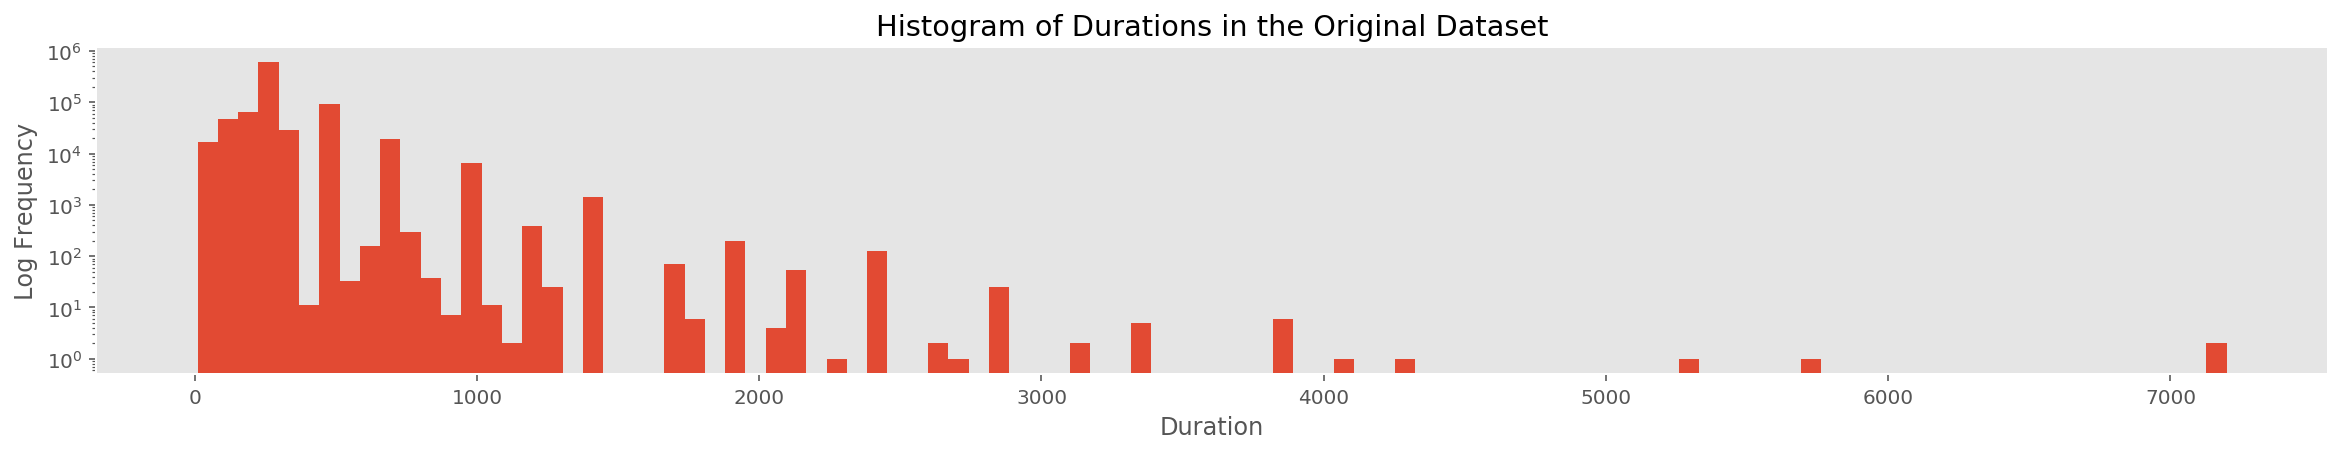

In [15]:
#Plot original dataset
plt.figure(figsize=(20, 3))
plt.hist(time_values_orig, bins=100)
plt.title('Histogram of Durations in the Original Dataset')
plt.ylabel('Log Frequency')
plt.xlabel('Duration')
plt.yscale('log')
plt.show()

In [16]:
from collections import Counter
frequency = Counter(time_values_orig) #get frequency of each tick duration
print("The frequencies are:", dict(frequency))
keys = {k: v for k, v in frequency.items() if v < 120}.keys() #get list of least frequent frequency durations

The frequencies are: {159: 64879, 79: 3024, 119: 46714, 239: 602244, 59: 13546, 359: 1174, 479: 91639, 719: 19142, 959: 6411, 949: 63, 469: 405, 1439: 1431, 1199: 377, 1679: 71, 319: 28015, 639: 110, 1919: 195, 599: 45, 839: 38, 179: 156, 89: 42, 2399: 127, 202: 1, 95: 1, 149: 88, 212: 42, 105: 44, 117: 2, 229: 586, 349: 41, 109: 80, 709: 80, 2159: 54, 799: 300, 559: 33, 3119: 2, 2879: 25, 2719: 1, 29: 90, 250: 1, 39: 361, 309: 30, 279: 14, 160: 1, 230: 5, 1279: 25, 480: 2, 1909: 2, 3839: 6, 2639: 2, 219: 11, 459: 6, 419: 6, 199: 4, 1759: 6, 699: 1, 1429: 2, 1079: 11, 2039: 4, 4319: 1, 939: 6, 929: 1, 692: 2, 209: 2, 49: 52, 10: 4, 3359: 5, 7199: 2, 5759: 1, 2239: 1, 5279: 1, 4079: 1, 1119: 2, 1200: 2, 399: 5, 299: 1}


In [17]:
counter = 0
new_dataset = {}
for i in dataset.keys():
    if list(filter(lambda x: x not in keys, dataset[i]['T'])) != dataset[i]['T']:
        counter += 1
    else:
        new_dataset[i] = dataset[i]
print('Percentage of melodies removed from the dataset:', counter/len(melodies_orig))

Percentage of melodies removed from the dataset: 0.04539530842745439


Note that if we remove all ticks with frequency <120, we only deprecate 4.5% of all melodies. We cannot improve this value, as the next step puts us above 5% at 5.06%.

In [18]:
#recomputing duration dictionary
set_T = set()
for key in new_dataset.keys():
    set_T = set_T.union(set(new_dataset[key]['T']))
    
new_T = sorted(list(set_T))
print('New T: ', new_T, '\nLength of T: ', len(new_T))

New T:  [39, 59, 79, 119, 159, 179, 229, 239, 319, 359, 469, 479, 719, 799, 959, 1199, 1439, 1919, 2399] 
Length of T:  19


In [19]:
melodies_new = [new_dataset[i]['T'] for i in new_dataset.keys()]
time_values_new = sum(melodies_new, []) #sum just does flatmap over list of lists

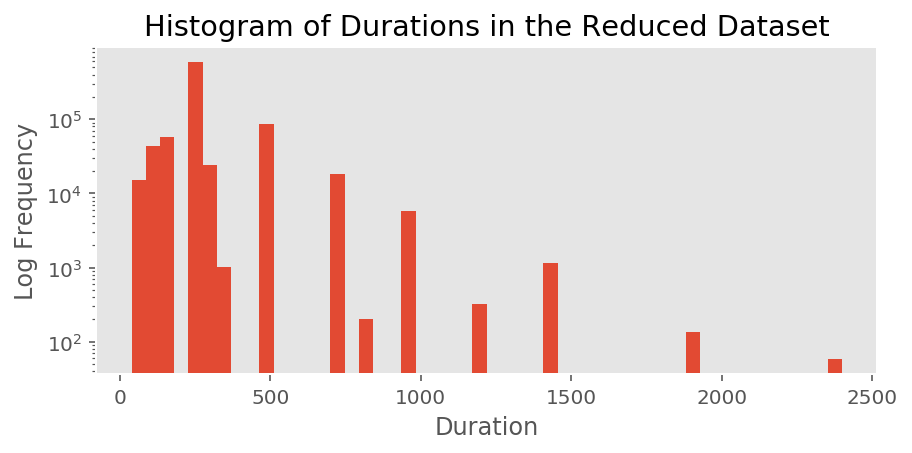

In [20]:
#Plot reduced dataset
plt.figure(figsize=(7,3))
plt.hist(time_values_new, bins=50)
plt.title('Histogram of Durations in the Reduced Dataset')
plt.ylabel('Log Frequency')
plt.xlabel('Duration')
plt.yscale('log')
plt.show()

In [21]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

We preform the transposition only once as it takes a long time to run. We then save it to a pickle file which we use.

In [22]:
#transposed_dataset = transposeDataset(new_dataset)
#save to pickle for now
#pickle.dump(transposed_dataset, open("data/transposed_dataset.pkl", "wb"))

with open('data/transposed_dataset.pkl', 'rb') as f:
    transposed_dataset = pickle.load(f)

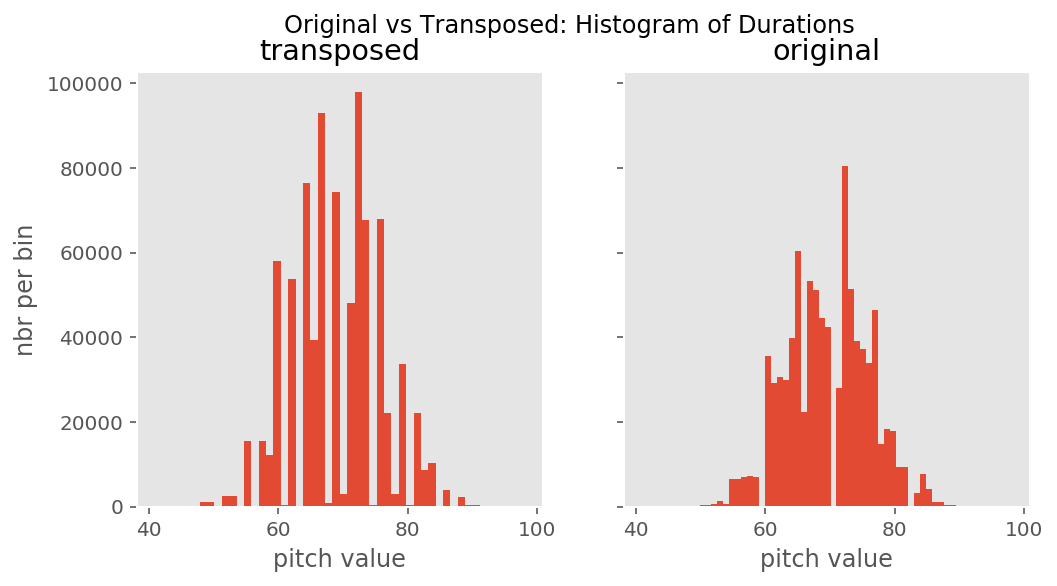

In [23]:
#extract pitch values (use sum to flatten structure here)
pitch_values = sum([dataset[i]['P'] for i in dataset.keys()], [])
pitch_values_trans = sum([transposed_dataset[i]['P'] for i in transposed_dataset.keys()], [])

#plot both histograms
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle('Original vs Transposed: Histogram of Durations')

ax1.set_title('transposed')
ax1.hist(pitch_values_trans, bins=50)
ax1.set_xlabel('pitch value')
ax1.set_ylabel('nbr per bin')

ax2.set_title('original')
ax2.hist(pitch_values, bins=50)
ax2.set_xlabel('pitch value')

plt.show()

In [24]:
#recompute dictionaries & add to dataset
for key in transposed_dataset.keys():
    set_P = set_P.union(set(transposed_dataset[key]['P']))
    
new_P = sorted(list(set_P))

#translate the dataset to integer representation
for key in transposed_dataset.keys():
    transposed_dataset[key]['T_integer'] = list(map(lambda x: new_T.index(x), transposed_dataset[key]['T']))
    transposed_dataset[key]['P_integer'] = list(map(lambda x: new_P.index(x), transposed_dataset[key]['P']))

In [25]:
#save to pickle for later
#dictionaries = {'T': new_T, 'P': new_P}
#pickle.dump(dictionaries, open("data/dictionaries.pkl", "wb"))

with open('data/dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?

In [29]:
print('Original length of T: {}'.format(len(set_T_orig)))
print('New length of T:      {}'.format(len(set_T)))
print('Shrinkage:            {}'.format(1.0 - len(set_T)/len(set_T_orig)))

Original length of T: 76
New length of T:      19
Shrinkage:            0.75


**Answer**: We have reduced the original duration range by 75% (see the cell above). In terms of training, it means that we'll have 75% shorter one-hot vectors that encode duration. Given that RNNs are asymptotically linear in the length of the input, this procedure significantly reduces training time.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: Transposition invariance as a property of the model means that if the model is given a number of melodies that only differ in tonality, the output will also only differ in tonality, i.e. all the outputs can be transposed to a single tonality, in which they are equal. This would mean that the model 'perceives' the transposed sequences the same. For generation, this would mean that the model can maintain the same tonality throughout the sequence.
And this is practically achieved with the second method, when we feed all possible tonalities of the same sequence to the model.

The first method is a way of 'cheating', because we don't give the model the opportunity to 'perceive' every tonality, but reduce the space to a single one. This approach significantly reduces computation time retaining the ability to produce sequences within the same tonality (because we initially showed only one). And after the sequence is generated, we can transpose as we like.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: If we keep the joint representation, each element of this representation is a one dimensional element, being of the space formed by the cross product of pitch and duration, rather than two dimensions if we separate them. 

The cardinality of the set of possible joint representations is smaller than the set of the crossproducts of the two separated features. 

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: The distribution would contain a few very frequent pitch/duration pairs and extremely many infrequent pairs. We plotted this distribution below:

In [32]:
#takes some time
Both = Counter(sum([list(zip(dataset[i]['T'], dataset[i]['P'])) for i in dataset.keys()], []))

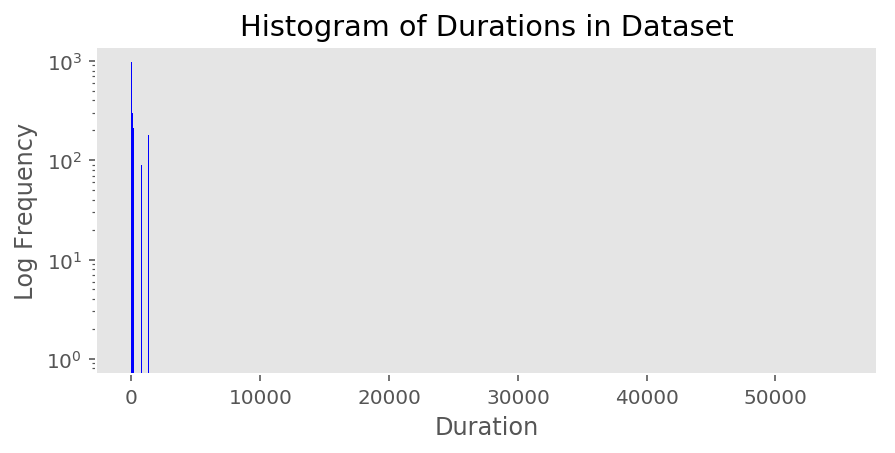

In [38]:
plt.figure(figsize=(7,3))
plt.bar(list(Both.values()), range(len(Both)), color='b')
plt.title('Histogram of Durations in Dataset')
plt.ylabel('Log Frequency')
plt.xlabel('Duration')
plt.yscale('log')
plt.show()

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

In [39]:
#oneHot encoding vectors
for key in transposed_dataset.keys():
    transposed_dataset[key]['T_matrix'] = keras.utils.to_categorical(transposed_dataset[key]['T_integer'], 
                                                                     num_classes=len(new_T))
    transposed_dataset[key]['P_matrix'] = keras.utils.to_categorical(transposed_dataset[key]['P_integer'], 
                                                                     num_classes=len(new_P))

In [40]:
for label in np.random.choice(list(transposed_dataset.keys()), 2):
    print(label)
    print("Integer representation:")
    print(transposed_dataset[label]['P_matrix'].shape)
    print("Integer representation:")
    print(transposed_dataset[label]['T_matrix'].shape)

sessiontune45729
Integer representation:
(182, 55)
Integer representation:
(182, 19)
sessiontune45649
Integer representation:
(255, 55)
Integer representation:
(255, 19)


There might be some rare very long melodies in your dataset, a possible choice is to set the `maxlen` argument of `pad_sequences()` to the _mean + 2std_ of the melody lengths. 
This ensures that 95% of your melodies would end before being truncated.

In [41]:
#calculate std and mean
length = [len(new_dataset[i]['T']) for i in new_dataset.keys()]
print(np.mean(length), np.std(length))
maxlen = int(np.ceil(np.mean(length) + 2*np.std(length)))

191.023890785 100.52361038


In [42]:
#swe pecify truncation/padding at end of sequence, not begining, as this makes more sense
T_matrix = pad_sequences([transposed_dataset[i]['T_matrix'] for i in transposed_dataset.keys()], maxlen=maxlen, 
                         padding='post', truncating='post')
print(T_matrix.shape)

P_matrix = pad_sequences([transposed_dataset[i]['P_matrix'] for i in transposed_dataset.keys()], maxlen=maxlen, 
                         padding='post', truncating='post')
print(P_matrix.shape)

(4395, 393, 19)
(4395, 393, 55)


In [43]:
#write padded value into dataset
for i, key in enumerate(transposed_dataset.keys()):
    transposed_dataset[key]['T_matrix'] = T_matrix[i]
    transposed_dataset[key]['P_matrix'] = P_matrix[i]

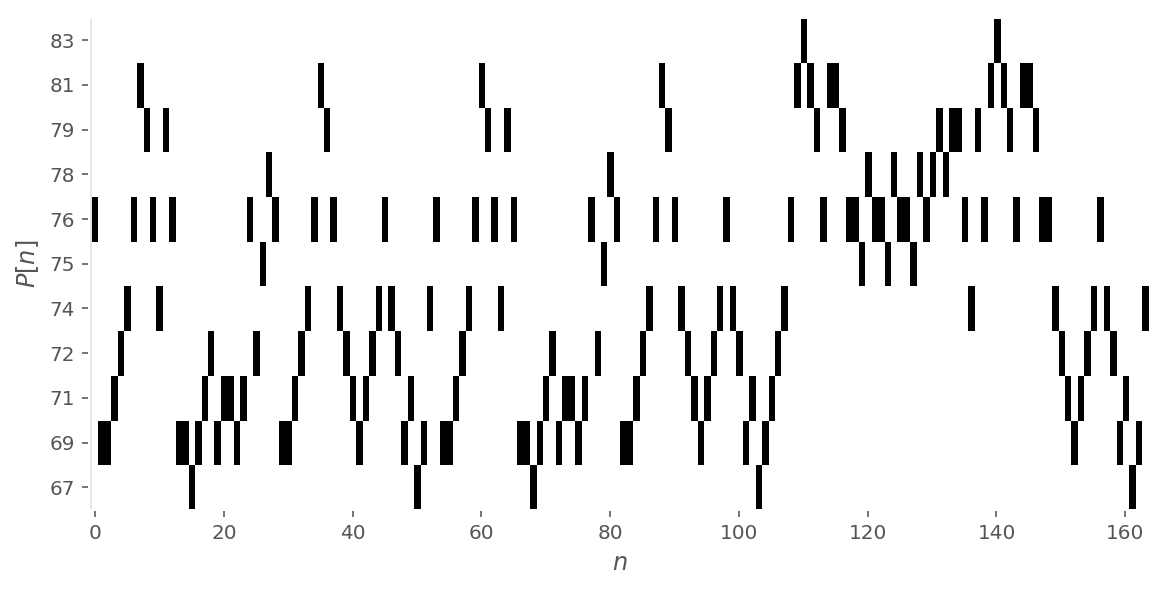

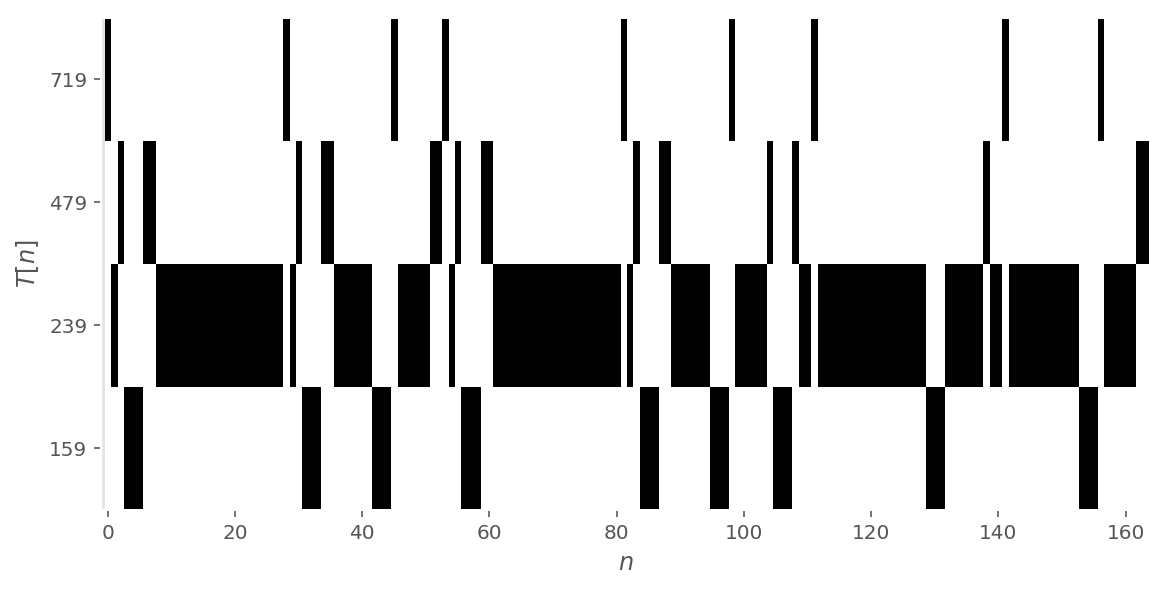

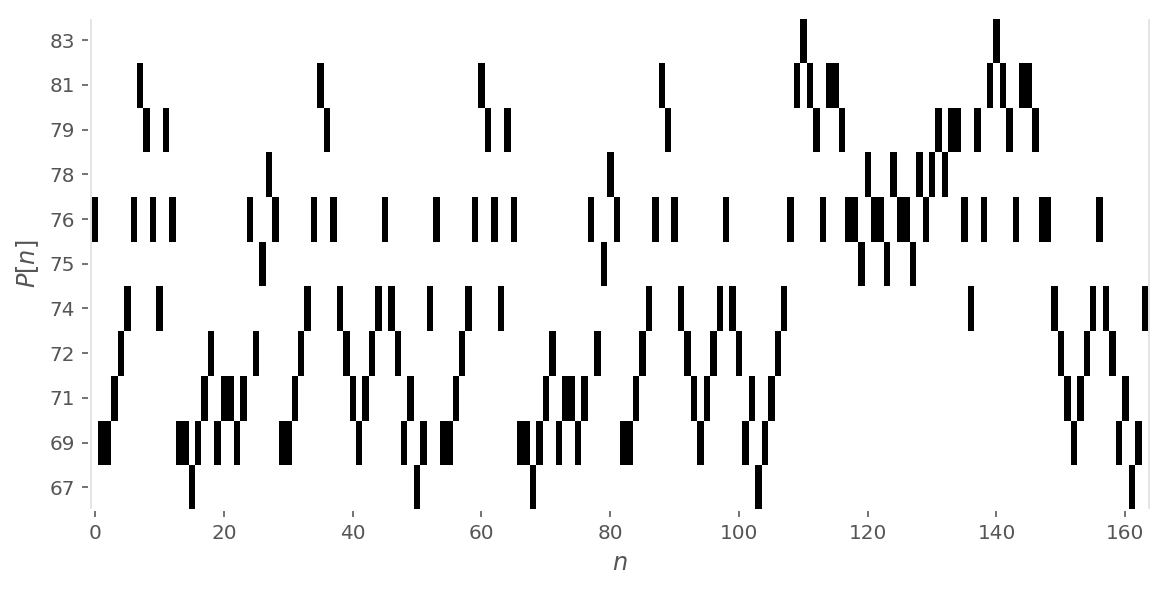

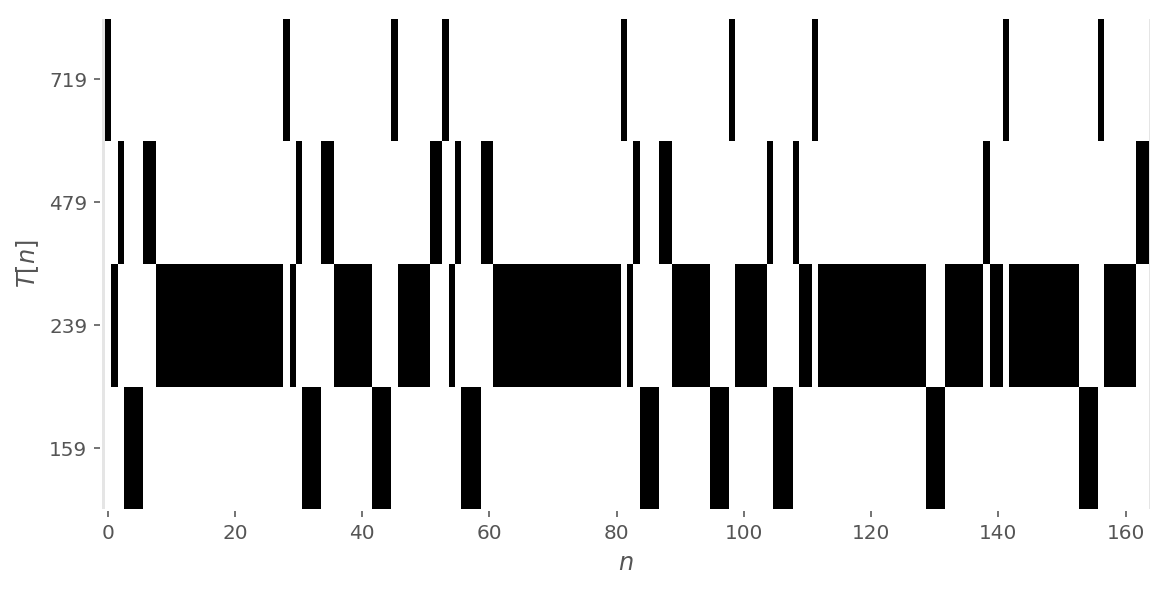

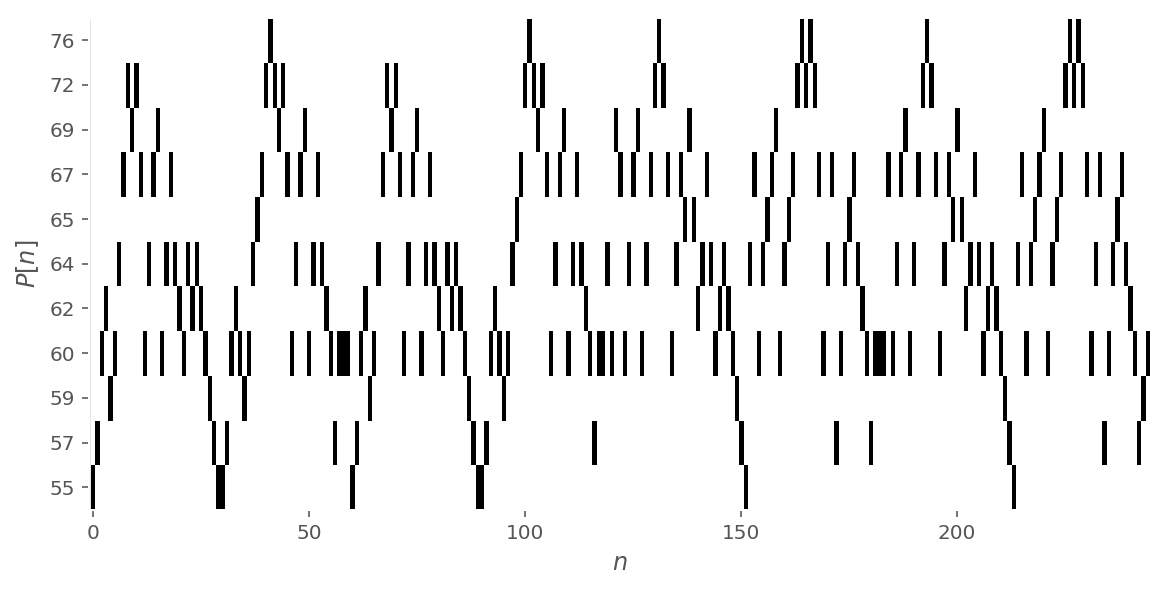

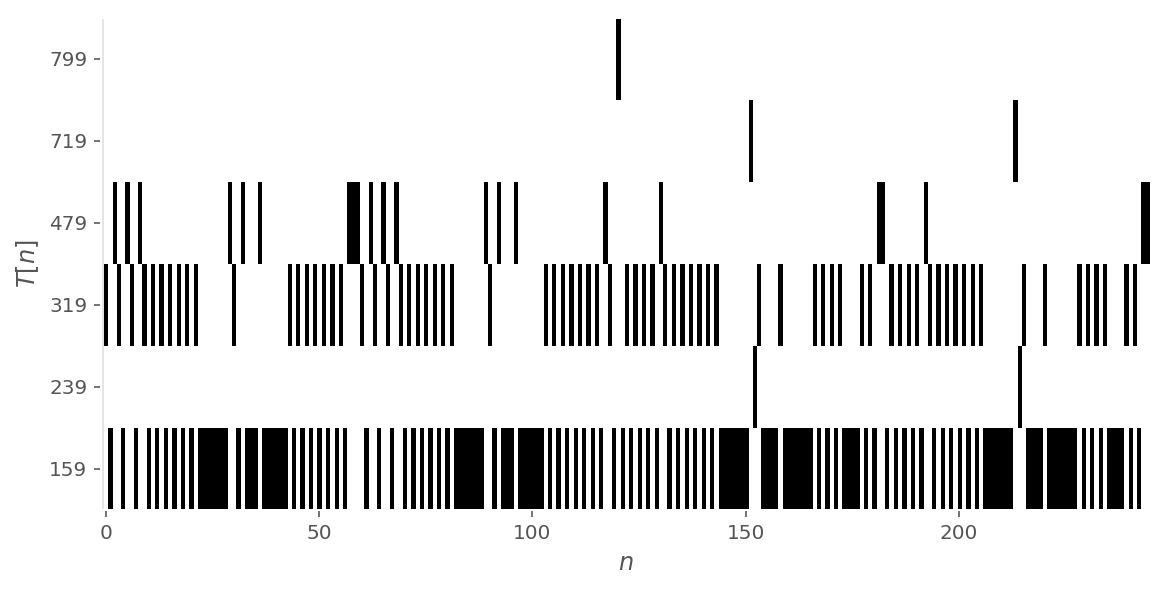

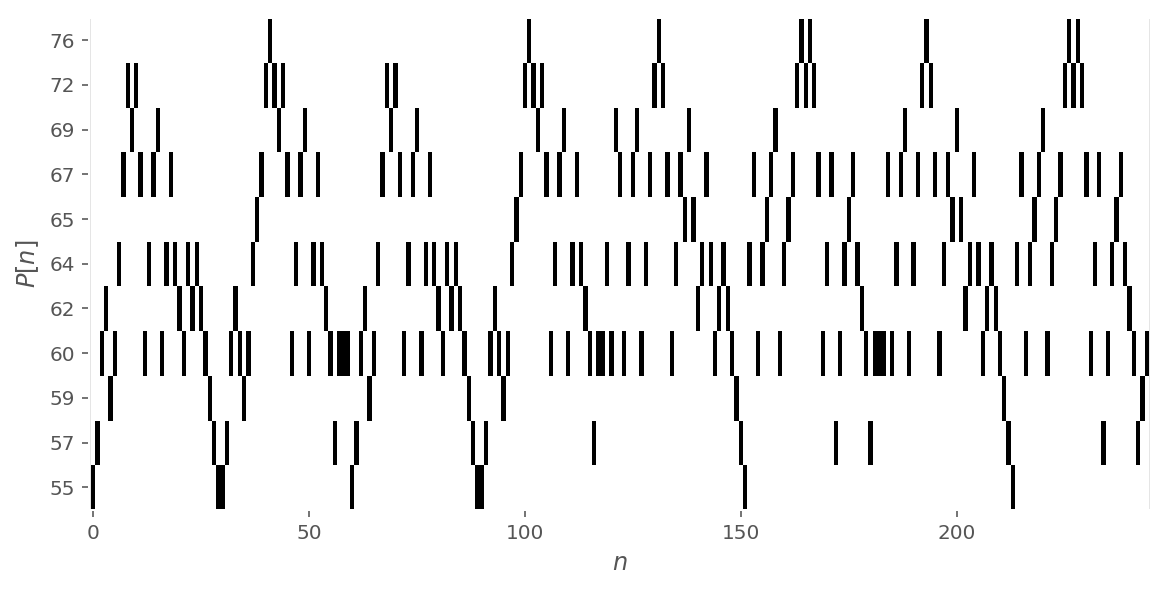

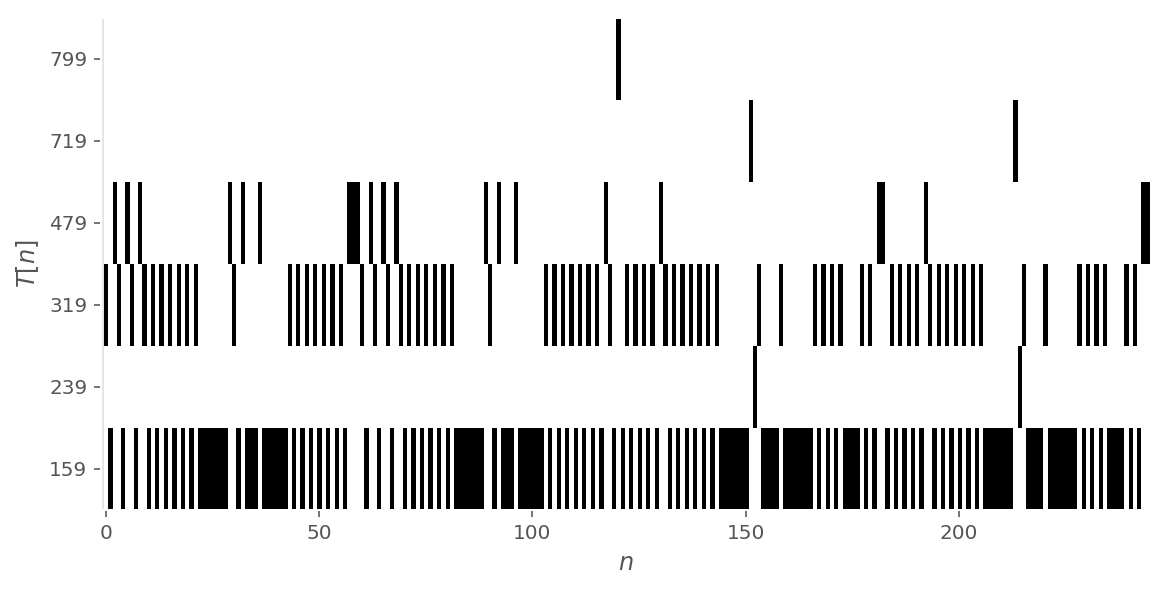

In [44]:
#verify correctness - looks correct
for label in np.random.choice(list(transposed_dataset.keys()), 2, replace=False):
    plotMelody(transposed_dataset[label]['P_matrix'], 
               transposed_dataset[label]['T_matrix'], dictionaries, PrP=None, PrT=None, H=None)
    plotMelody(transposed_dataset[label]['P_integer'],
               transposed_dataset[label]['T_integer'], dictionaries, PrP=None, PrT=None, H=None)

In [45]:
#save to pickle for now
#pickle.dump(transposed_dataset, open("data/transposed_dataset_oneHot.pkl", "wb"))

#with open('data/transposed_dataset_oneHot.pkl', 'rb') as f:
#    transposed_dataset = pickle.load(f)

#redefine values if we load from dataset
T_matrix = [transposed_dataset[i]['T_matrix'] for i in transposed_dataset.keys()]
P_matrix = [transposed_dataset[i]['P_matrix'] for i in transposed_dataset.keys()]

np.save('data/T_matrix.npy', np.array(T_matrix))
np.save('data/P_matrix.npy', np.array(P_matrix))

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [46]:
maxlen = 393 #as calculated in 4, define explicitly to not have to rerun computation
P_matrix = np.load('data/P_matrix.npy')
T_matrix = np.load('data/T_matrix.npy')
with open('data/dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)

In [47]:
# input = first element to n-1
XP = np.array(list(map(lambda x: x[:-1], P_matrix)))
XT = np.array(list(map(lambda x: x[:-1], T_matrix)))

# output = second element to last element
YP = np.array(list(map(lambda x: x[1:], P_matrix)))
YT = np.array(list(map(lambda x: x[1:], T_matrix)))

In [48]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        #Your hidden layer(s) architecture with GRU
        H['2'] = GRU(Hsize, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)(H['1'])
    elif activation == 'LSTM':
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        H['2'] = LSTM(Hsize, recurrent_dropout=0.25, return_sequences=True)(H['1'])
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        H['2'] = SimpleRNN(Hsize, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)(H['1'])
    
    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])

    return model

1\. **RNN**

In [49]:
RNNmodel = buildModel(dictionaries, 
                      batch_length=maxlen-1, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')

RNNmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 392, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 392, 55)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 392, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 392, 55)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [ ]:
# Computed on cluster.
epochs = 50 #no worries it's 250 epochs! see below

for i in range(5):
    history = RNNmodel.fit([XT, XP], [YT, YP], batch_size=128, \
                           epochs=epochs, validation_split=0.2, verbose=2) #validation split 80:20
    with open('output/rnn/history_{}.pkl'.format(i), 'wb') as f:
        pickle.dump(history.history, f)
    with open('output/rnn/weights_{}.pkl'.format(i), 'wb') as f:
        pickle.dump(RNNmodel.get_weights(), f)

In [50]:
with open('output/rnn/history_0.pkl', 'rb') as f:
    rnn_hist = pickle.load(f)

for i in range(1, 5):
    with open('output/rnn/history_{}.pkl'.format(i), 'rb') as f:
        new_hist = pickle.load(f)
        for key in rnn_hist.keys():
            rnn_hist[key] = rnn_hist[key] + new_hist[key]

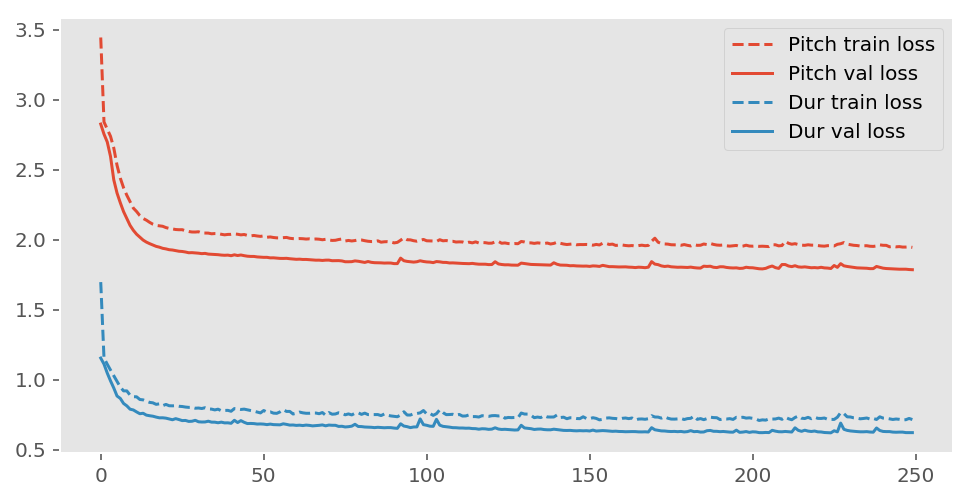

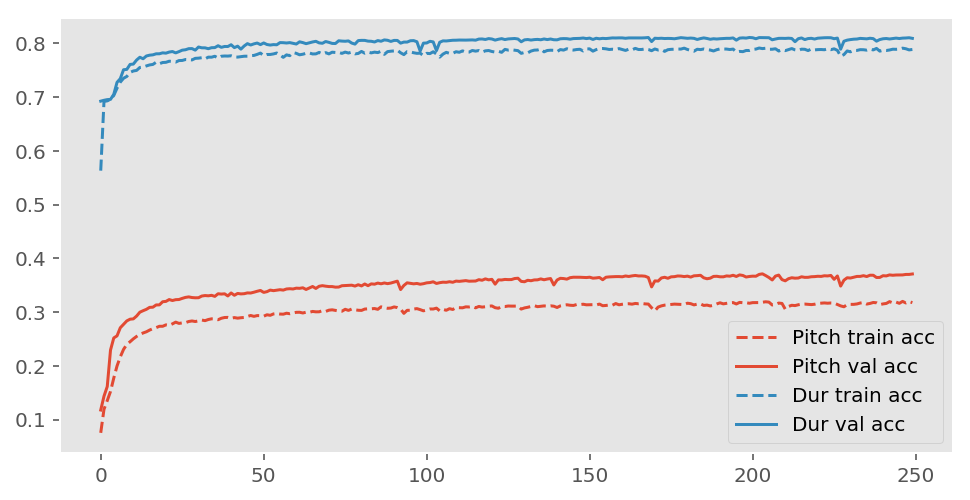

In [51]:
plotLearningCurves(rnn_hist)

2\. **GRU**

In [52]:
GRUmodel = buildModel(dictionaries, 
                      batch_length=maxlen-1, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU')

GRUmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 392, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 392, 55)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 392, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 392, 55)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [ ]:
# Computed on cluster.
epochs = 50

for i in range(5):
    history = GRUmodel.fit([XT, XP], [YT, YP], batch_size=128, \
                           epochs=epochs, validation_split=0.2, verbose=2) #validation split
    with open('output/gru/history_{}.pkl'.format(i), 'wb') as f:
        pickle.dump(history.history, f)
    with open('output/gru/weights_{}.pkl'.format(i), 'wb') as f:
        pickle.dump(GRUmodel.get_weights(), f)

In [53]:
with open('output/gru/history_0.pkl', 'rb') as f:
    gru_hist = pickle.load(f)

for i in range(1, 5):
    with open('output/gru/history_{}.pkl'.format(i), 'rb') as f:
        new_hist = pickle.load(f)
        for key in gru_hist.keys():
            gru_hist[key] = gru_hist[key] + new_hist[key]

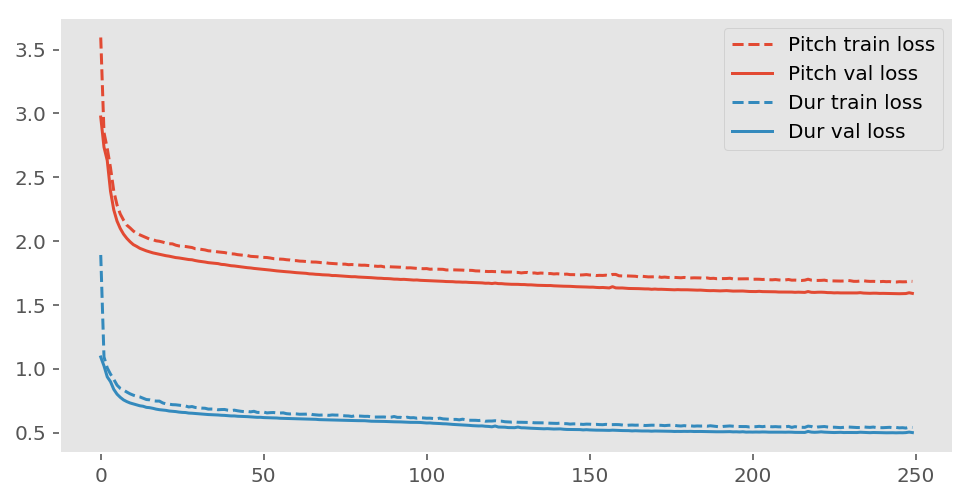

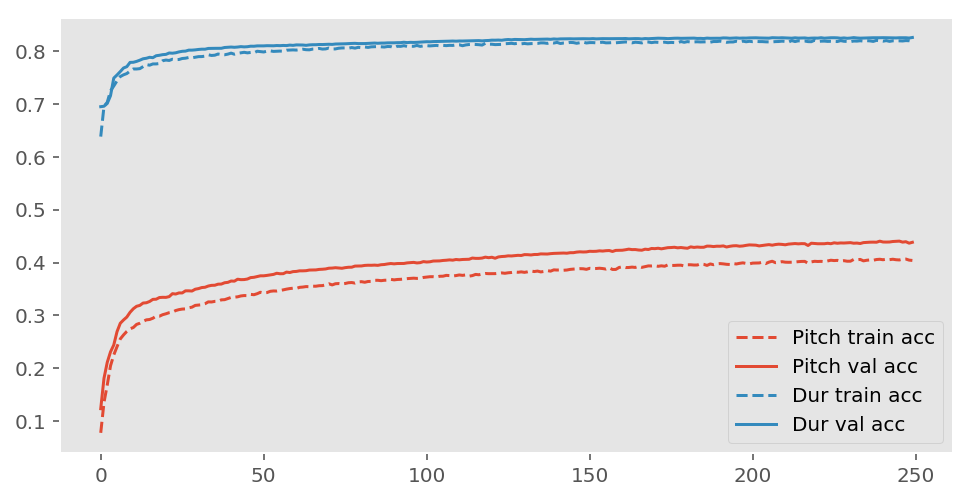

In [54]:
plotLearningCurves(gru_hist)

3\. **RNN vs GRU**

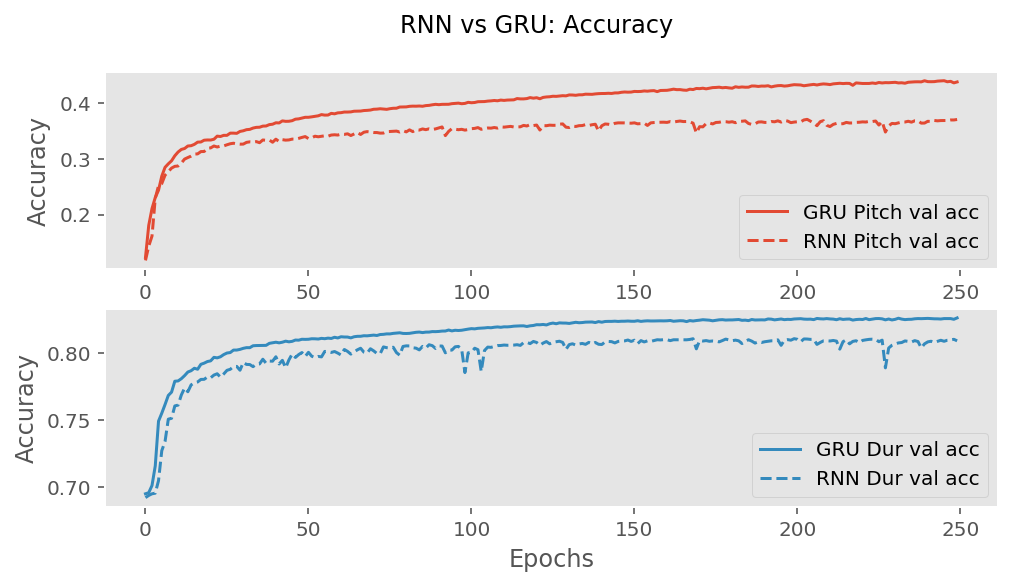

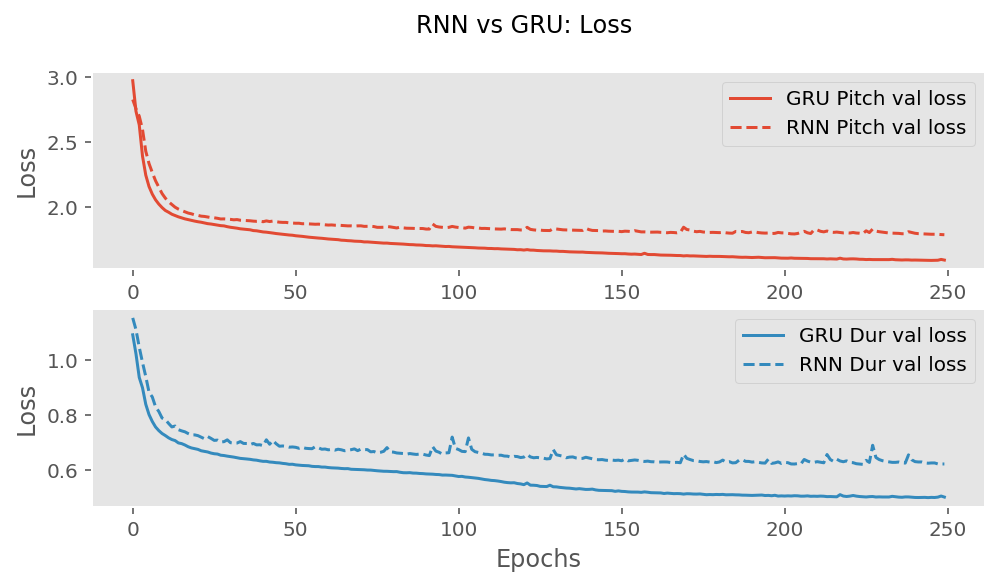

Best prediction accuracies
RNN
Pitch:    0.3711963451898681
Duration: 0.8108725671882109
GRU
Pitch:    0.4406, 18.70% more
Duration: 0.8263, 1.91% more

Best model: GRU


In [55]:
#Plot accuracies
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(gru_hist['val_YP_acc'], c=c[0], label='GRU Pitch val acc')
ax1.plot(rnn_hist['val_YP_acc'], c=c[0], linestyle='--', label='RNN Pitch val acc')
ax2.plot(gru_hist['val_YT_acc'], c=c[1], label='GRU Dur val acc')
ax2.plot(rnn_hist['val_YT_acc'], c=c[1], linestyle='--', label='RNN Dur val acc')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')
plt.suptitle('RNN vs GRU: Accuracy')
plt.show()

#Plot loss
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(gru_hist['val_YP_loss'], c=c[0], label='GRU Pitch val loss')
ax1.plot(rnn_hist['val_YP_loss'], c=c[0], linestyle='--', label='RNN Pitch val loss')
ax1.legend(loc='best')

ax2.plot(gru_hist['val_YT_loss'], c=c[1], label='GRU Dur val loss')
ax2.plot(rnn_hist['val_YT_loss'], c=c[1], linestyle='--', label='RNN Dur val loss')
ax2.legend(loc='best')
plt.xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Loss')
plt.suptitle('RNN vs GRU: Loss')
plt.show()

#Get best predictions:
rp = np.max(rnn_hist['val_YP_acc'])
rd = np.max(rnn_hist['val_YT_acc'])
gp = np.max(gru_hist['val_YP_acc'])
gd = np.max(gru_hist['val_YT_acc'])
print('Best prediction accuracies')
print('RNN')
print('Pitch:    {}'.format(rp))
print('Duration: {}'.format(rd))
print('GRU')
print('Pitch:    {:.4f}, {:.2f}% more'.format(gp, (gp-rp)/rp*100))
print('Duration: {:.4f}, {:.2f}% more'.format(gd, (gd-rd)/rd*100))
print('\nBest model: GRU')

**Question**: What are the best prediction accuracies you obtained? With which model?

**Answer**: GRU outpreforms RNN, especialy in pitch prediction. See the cell above for details.

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.

**Answer**: Learning curves for RNN and GRU have different horizontal asymptotes, those of GRU gaining better scores. Also, GRU learning curves are smoother while RNN ones have systematical setbacks, that are seen as dips in the curves. 


## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

1\. Outputs of the best model fed with 4 randomly selected melodies + prediction accuracies.

In [56]:
#load from external dataset to allow for selective evaluation
maxlen = 393
P_matrix = np.load('data/P_matrix.npy')
T_matrix = np.load('data/T_matrix.npy')
with open('data/dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)

In [57]:
# input = first element to n-1
XP = np.array(list(map(lambda x: x[:-1], P_matrix)))
XT = np.array(list(map(lambda x: x[:-1], T_matrix)))

# output = second element to last element
YP = np.array(list(map(lambda x: x[1:], P_matrix)))
YT = np.array(list(map(lambda x: x[1:], T_matrix)))

In [58]:
GRUmodel = buildModel(dictionaries, 
                      batch_length=maxlen-1, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU')

with open('output/gru/weights_4.pkl', 'rb') as f:
    GRUmodel.set_weights(pickle.load(f))

1
Melody No 2459


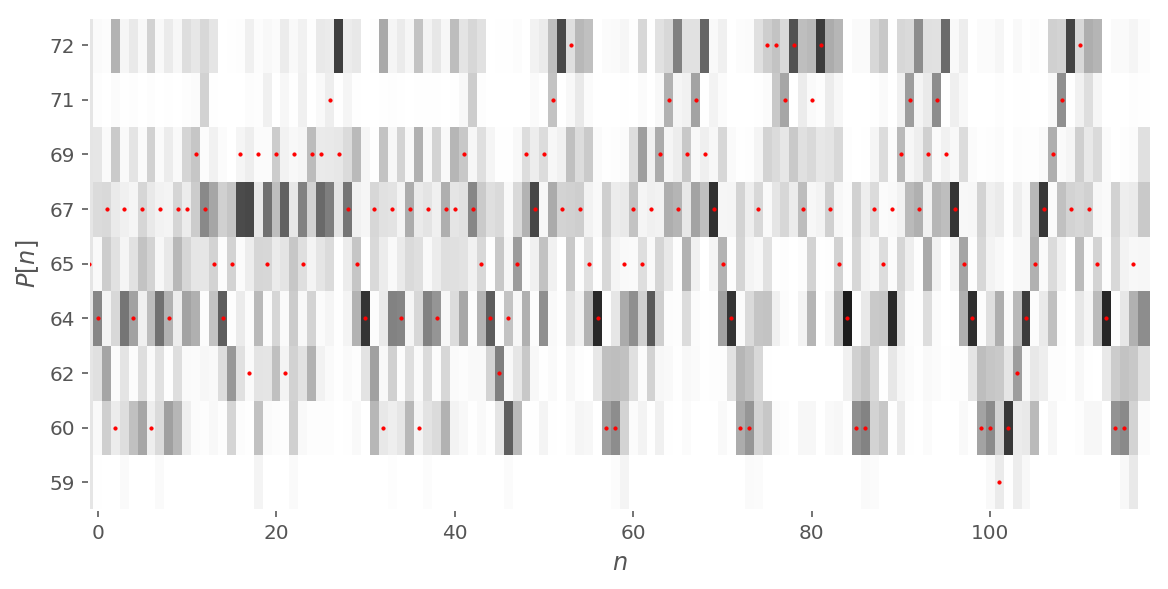

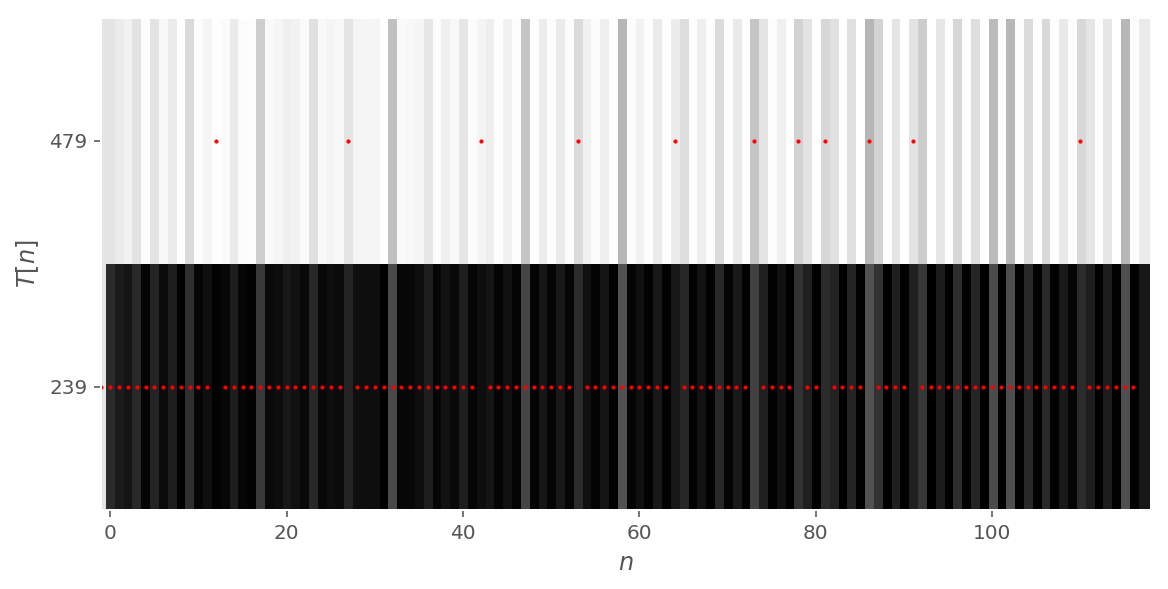

YT_acc: 0.8983051776885986
YP_acc: 0.4152541756629944
YT_acc_nopadding: 0.905982905982906
YP_acc_nopadding: 0.4188034188034188


2
Melody No 1116


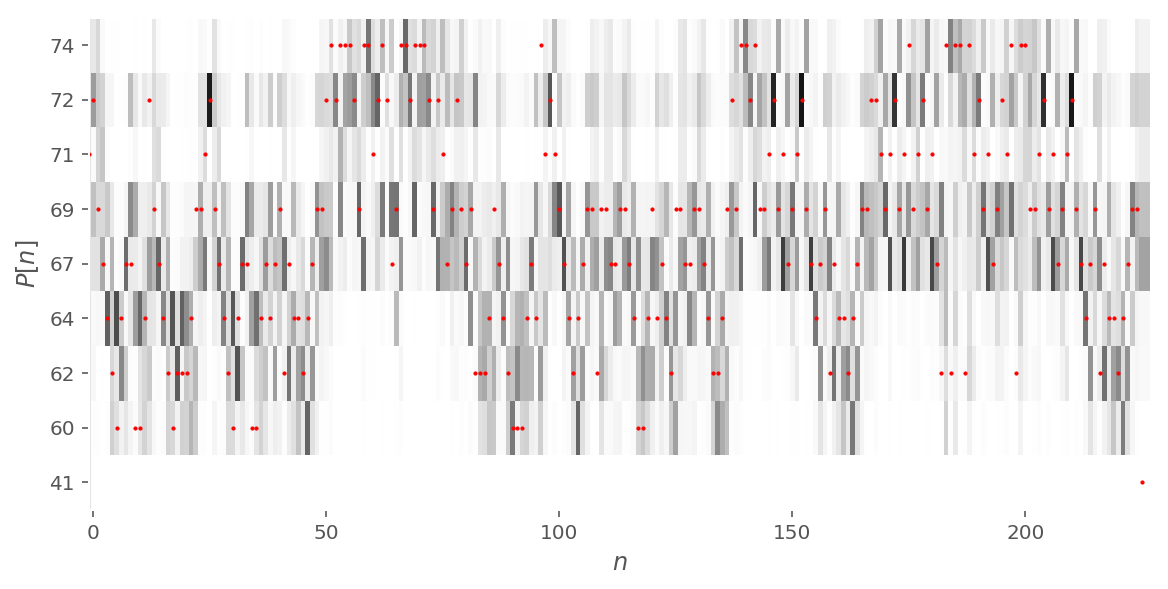

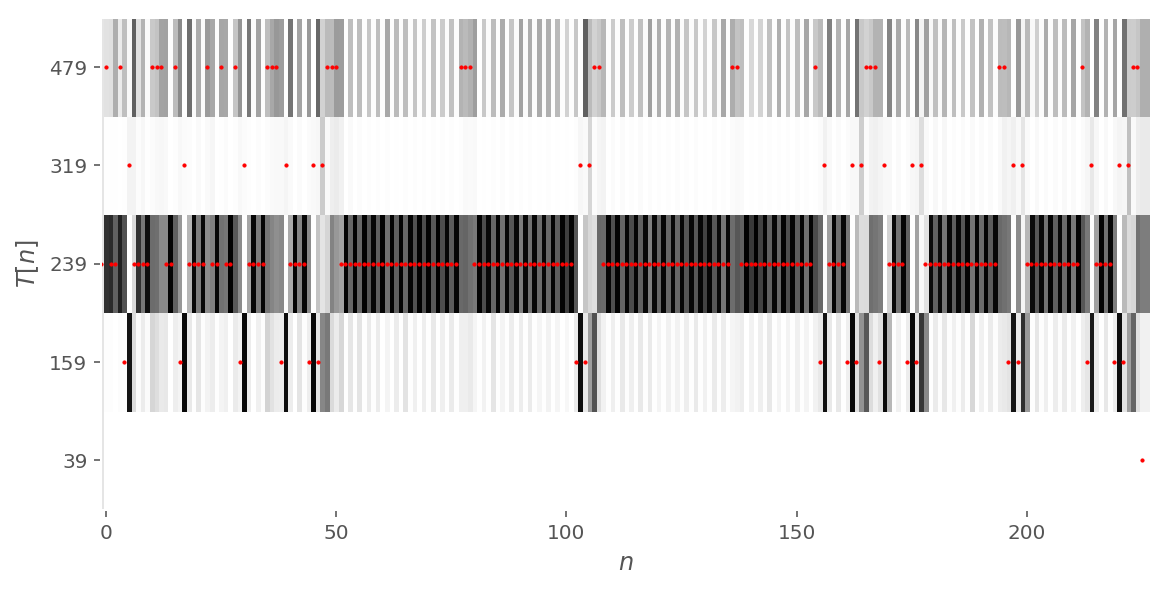

YT_acc: 0.6460174322128296
YP_acc: 0.4070794880390167
YT_acc_nopadding: 0.6460176991150443
YP_acc_nopadding: 0.40707964601769914


3
Melody No 1430


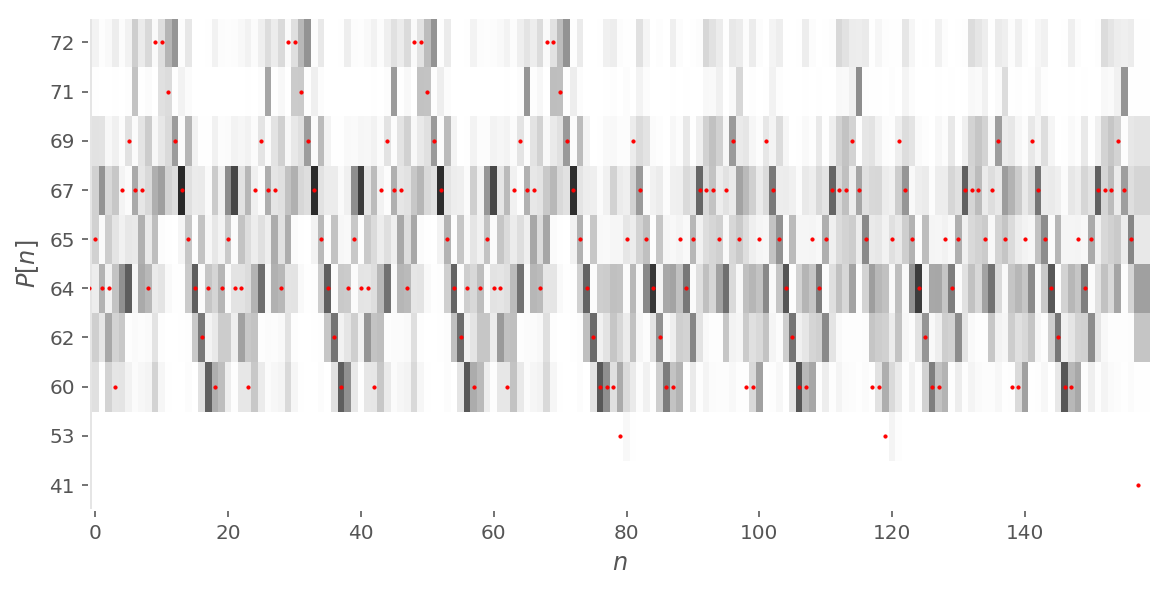

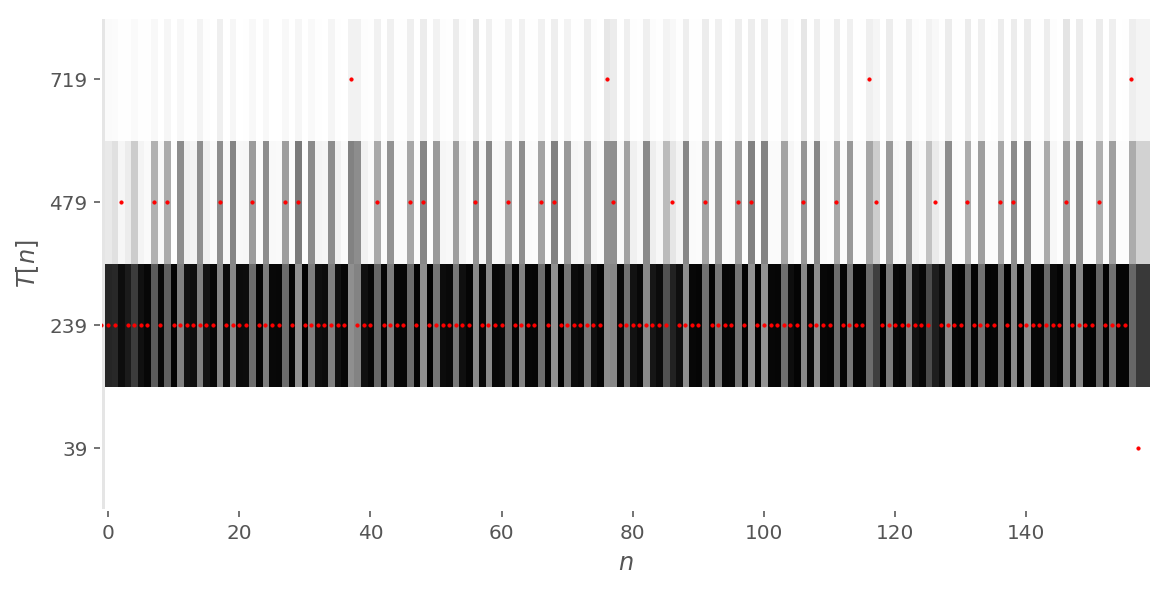

YT_acc: 0.7784810662269592
YP_acc: 0.3734177052974701
YT_acc_nopadding: 0.7784810126582279
YP_acc_nopadding: 0.37341772151898733


4
Melody No 76


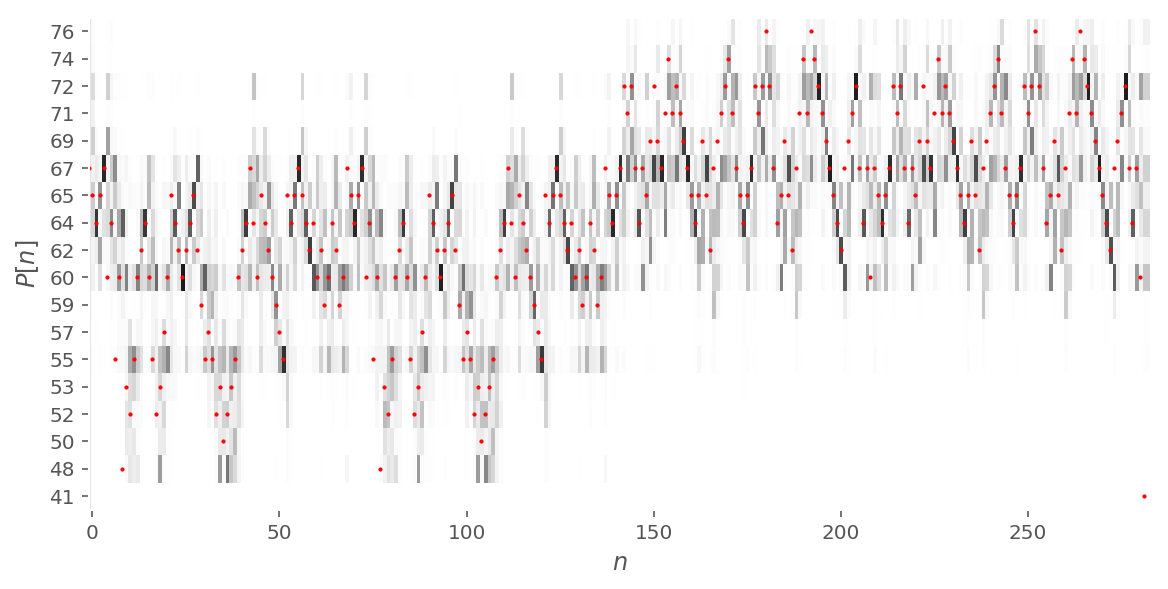

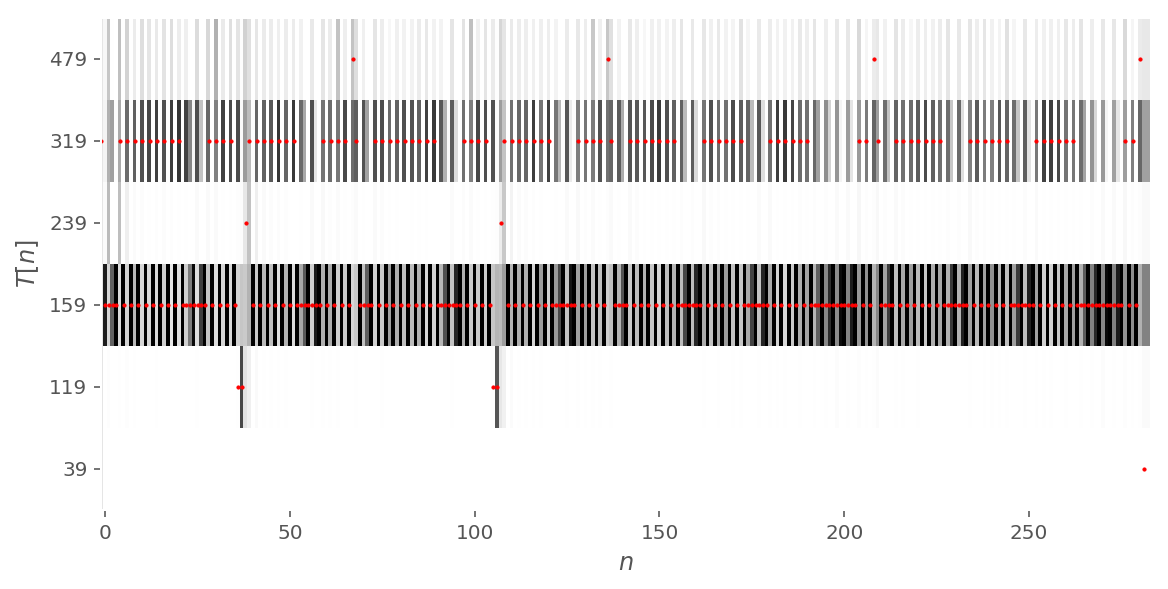

YT_acc: 0.8723403215408325
YP_acc: 0.517730712890625
YT_acc_nopadding: 0.8723404255319149
YP_acc_nopadding: 0.5177304964539007




In [59]:
BestModel = GRUmodel
counter = 0

labels = np.random.choice(P_matrix.shape[0], 4, replace=False)
for label in labels:
    counter += 1
    print(counter)
    print('Melody No', label)
    P = P_matrix[label]
    T = T_matrix[label]
    X = [np.array([T[:-1]]), np.array([P[:-1]])]
    Y = [np.array([T[1:]]), np.array([P[1:]])]
    
    pred_T, pred_P = BestModel.predict(X)
    
    padded = np.argmax(pred_P[0], axis=1)[::-1]
    tmp = padded[0]
    for s in range(len(padded)):
        if tmp != padded[s]:
            break
    s = s-1
    
    #print('Original')
    plotMelody(np.argmax(P, axis=1)[:-s], np.argmax(T, axis=1)[:-s], 
               PrP=pred_P[0],PrT=pred_T[0], dictionaries=dictionaries)
    #print('Prediction')
    #plotMelody(np.argmax(pred_P[0], axis=1)[:-s], np.argmax(pred_T[0], axis=1)[:-s],dictionaries=dictionaries)
    
    evals = BestModel.evaluate(X, Y, verbose=0)
    for i, metric in enumerate(evals):
        if BestModel.metrics_names[i].endswith('acc'):
            print("{}: {}".format(BestModel.metrics_names[i], metric))

# We thought that accuracy might be calculated including padding in keras. But it turned out to be wrong.
    print('YT_acc_nopadding: {}'.format(sum([x == y for x, y in zip(np.argmax(pred_T[0], axis=1)[:-s], \
                                                                    np.argmax(T[1:], axis=1)[:-s])])/(392-s)))
    print('YP_acc_nopadding: {}'.format(sum([x == y for x, y in zip(np.argmax(pred_P[0], axis=1)[:-i], \
                                                                    np.argmax(P[1:], axis=1)[:-s])])/(392-s)))
    print('\n')

2\. State evolution.

In [60]:
def buildStateModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    
    if activation == 'GRU':
        #Your hidden layer(s) architecture with GRU
        H['2'] = GRU(Hsize, 
                     dropout=0.25, 
                     recurrent_dropout=0.25, 
                     return_sequences=True,
                     name='recurrent_layer')(H['1'])
        
    elif activation == 'LSTM':
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        H['2'] = LSTM(Hsize, 
                      dropout=0.25, 
                      recurrent_dropout=0.25, 
                      return_sequences=True, 
                      name='recurrent_layer')(H['1'])
        
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        H['2'] = SimpleRNN(Hsize, 
                           dropout=0.25, 
                           recurrent_dropout=0.25, 
                           return_sequences=True,
                           name='recurrent_layer')(H['1'])
    
    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P'], H['2']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    
    return model

In [61]:
GRUstatemodel = buildStateModel(dictionaries, 
                      batch_length=maxlen-1, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU')

with open('output/gru/weights_4.pkl', 'rb') as f:
    GRUstatemodel.set_weights(pickle.load(f))

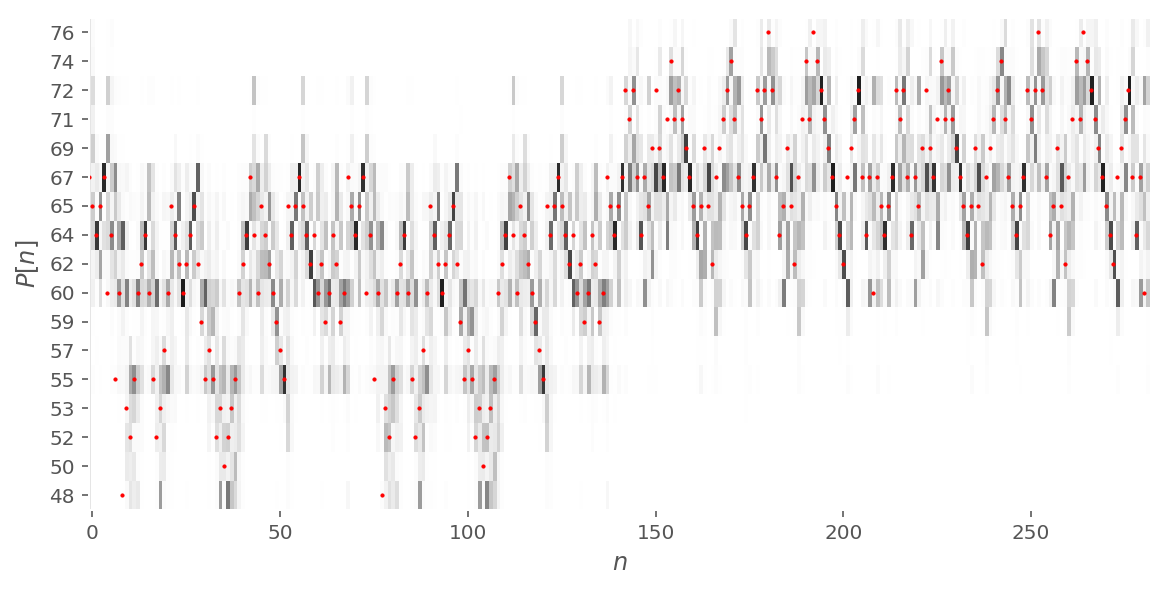

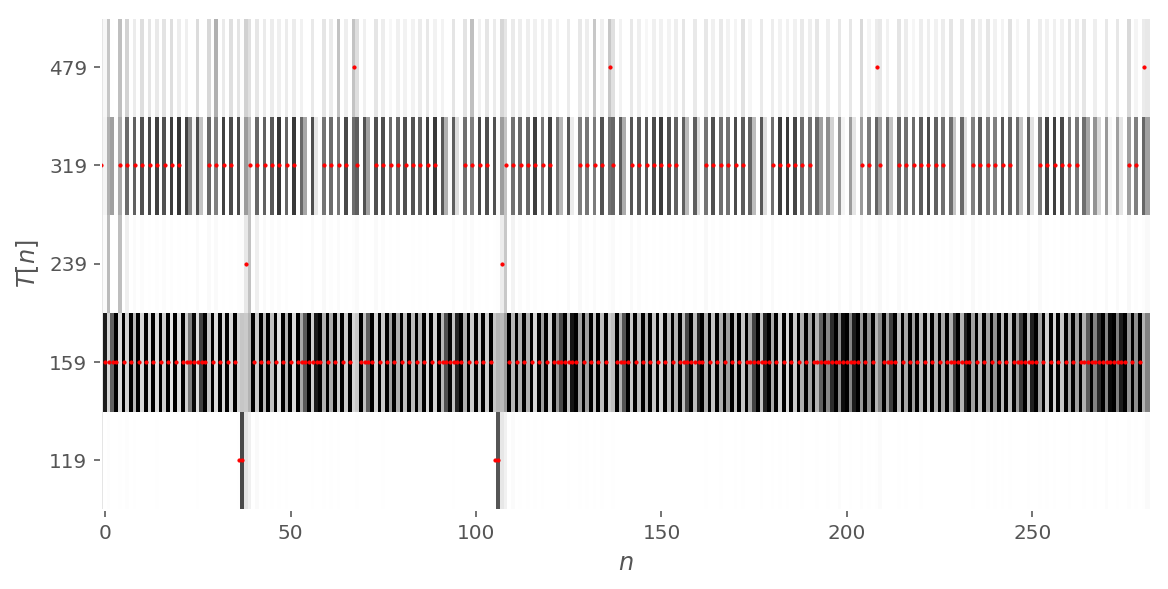

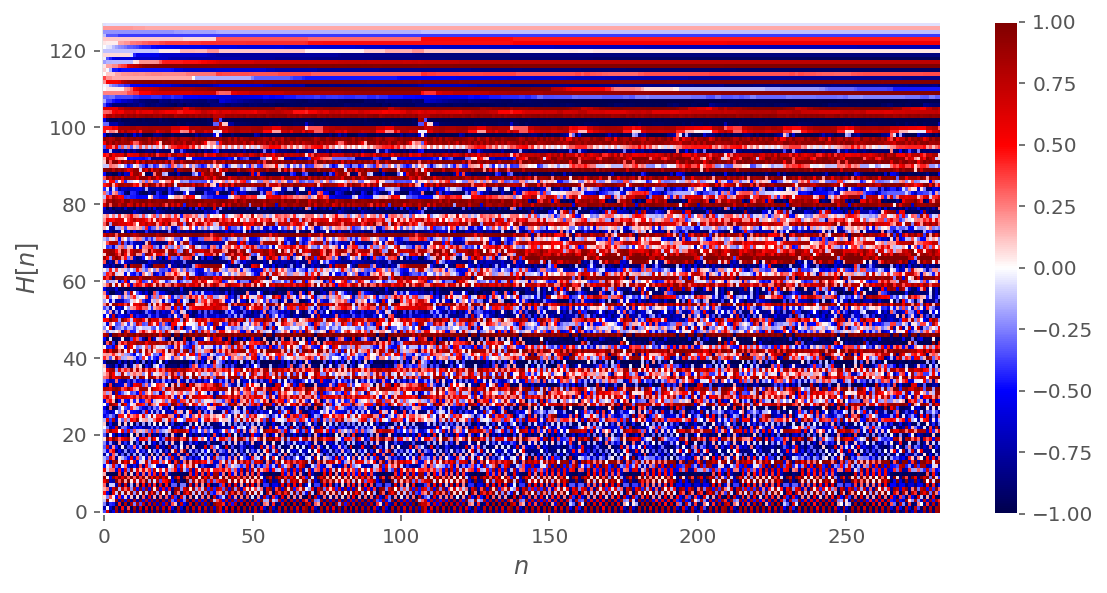

In [62]:
X_, Y_, S = GRUstatemodel.predict(X)

plotMelody(P, T, dictionaries=dictionaries, PrP=Y_[0], PrT=X_[0], H=S[0])

3\. Average absolute change in activation.

In [63]:
def get_diffs(model):
    avg = []
    for i in range(len(XP)):
        if i % 500 == 0:
            print('{}/{}'.format(i, len(XP)))
        P = XP[i]
        T = XT[i]
        xlim = [-1, np.where(P==1)[0][-1] + 1] # Is it here that we account for not including masked zeros?

        X = [np.array([T]), np.array([P])]
        a, b, H = model.predict(X)
        H = H[0]

        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        avg.append(diff)
    return np.array(avg)

In [ ]:
# Takes ~15 mins to calculate.
%time GRUavg = get_diffs(GRUstatemodel)

In [64]:
RNNstatemodel = buildStateModel(dictionaries, 
                      batch_length=maxlen-1, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')

with open('output/rnn/weights_4.pkl', 'rb') as f:
    RNNstatemodel.set_weights(pickle.load(f))

In [ ]:
# Takes ~15 mins to calculate.
%time RNNavg = get_diffs(RNNstatemodel)

In [ ]:
#with open('data/RNNavg.pkl', 'wb') as f:
#    pickle.dump(RNNavg, f)
#with open('data/GRUavg.pkl', 'wb') as f:
#    pickle.dump(GRUavg, f)

In [65]:
with open('data/RNNavg.pkl', 'rb') as f:
    RNNavg = pickle.load(f)
with open('data/GRUavg.pkl', 'rb') as f:
    GRUavg = pickle.load(f)

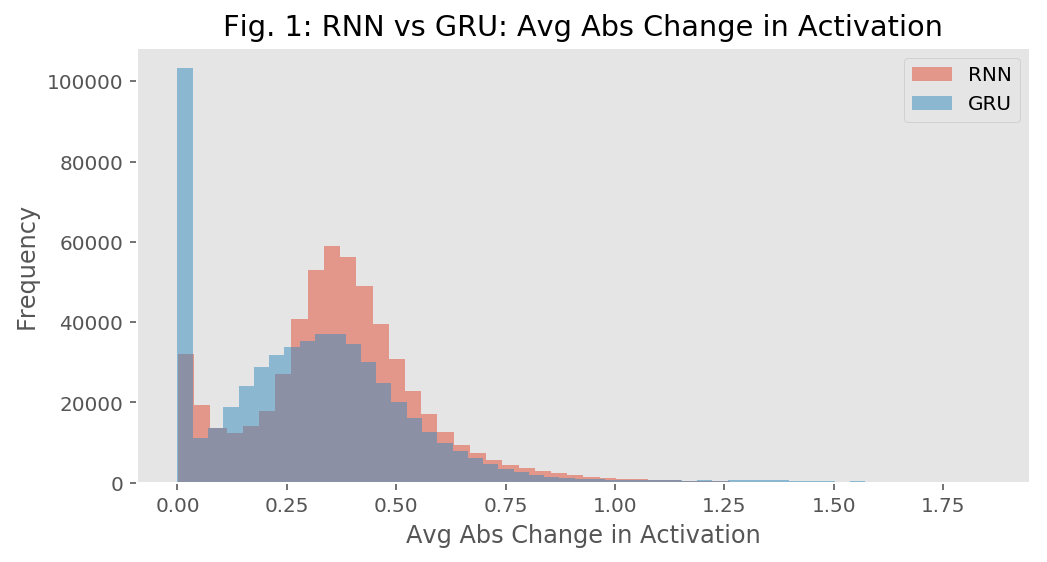

In [125]:
plot1 = plt.hist(np.array(RNNavg).flatten(), 50, alpha=0.5, label='RNN')
plot2 = plt.hist(np.array(GRUavg).flatten(), 50, alpha=0.5, label='GRU')
plt.xlabel('Avg Abs Change in Activation')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fig. 1: RNN vs GRU: Avg Abs Change in Activation')
plt.show()

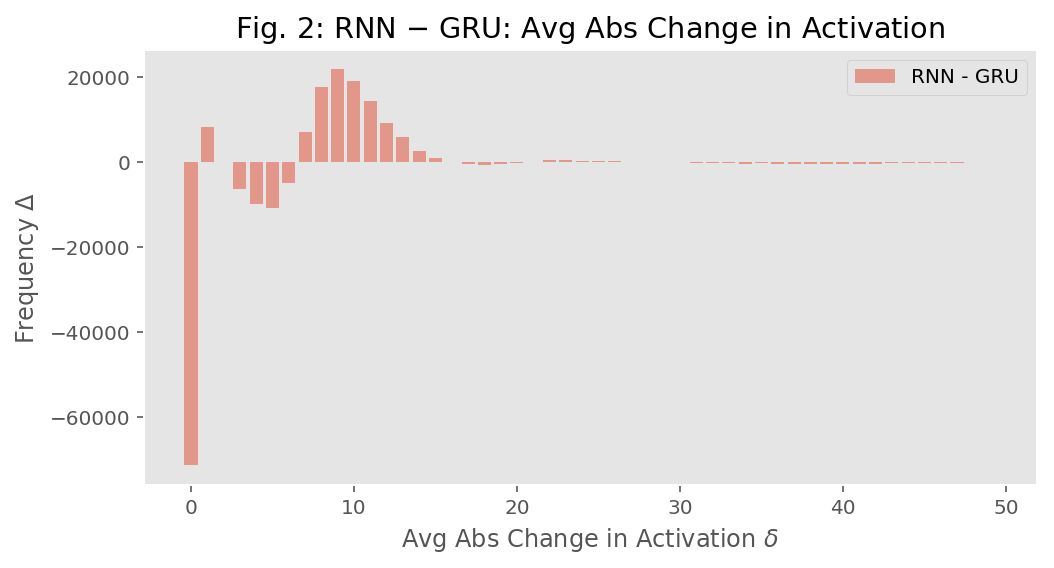

In [126]:
plt.bar(np.arange(50), plot1[0] - plot2[0], alpha=0.5, label='RNN - GRU')
plt.xlabel('Avg Abs Change in Activation $\delta$')
plt.ylabel('Frequency $\Delta$')
plt.legend()
plt.title('Fig. 2: RNN $-$ GRU: Avg Abs Change in Activation')
plt.show()

                           Fig. 3: GRU


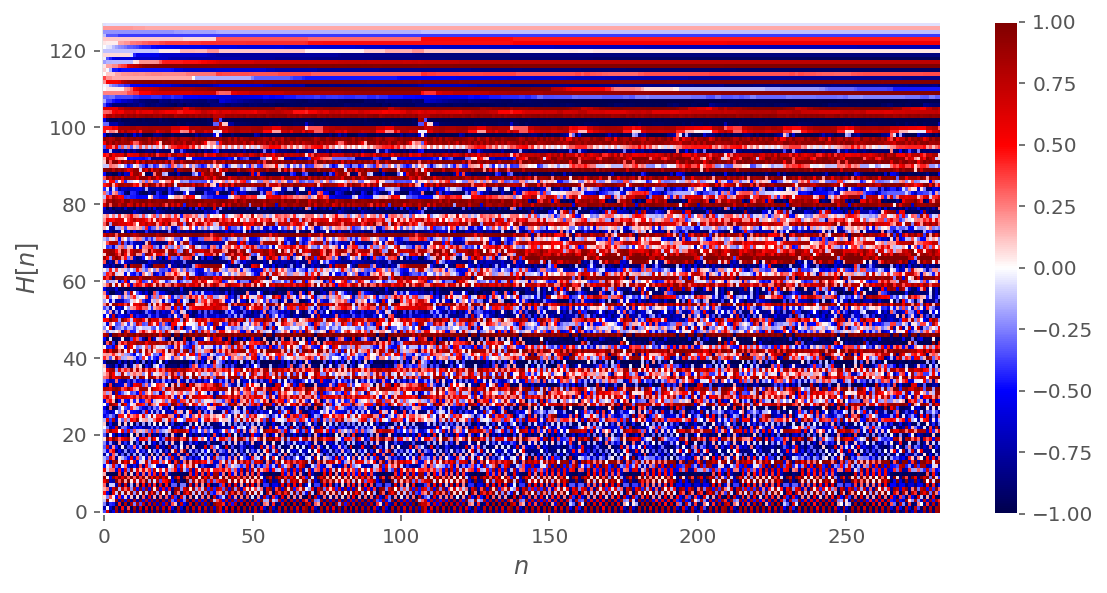

                           Fig. 4: RNN


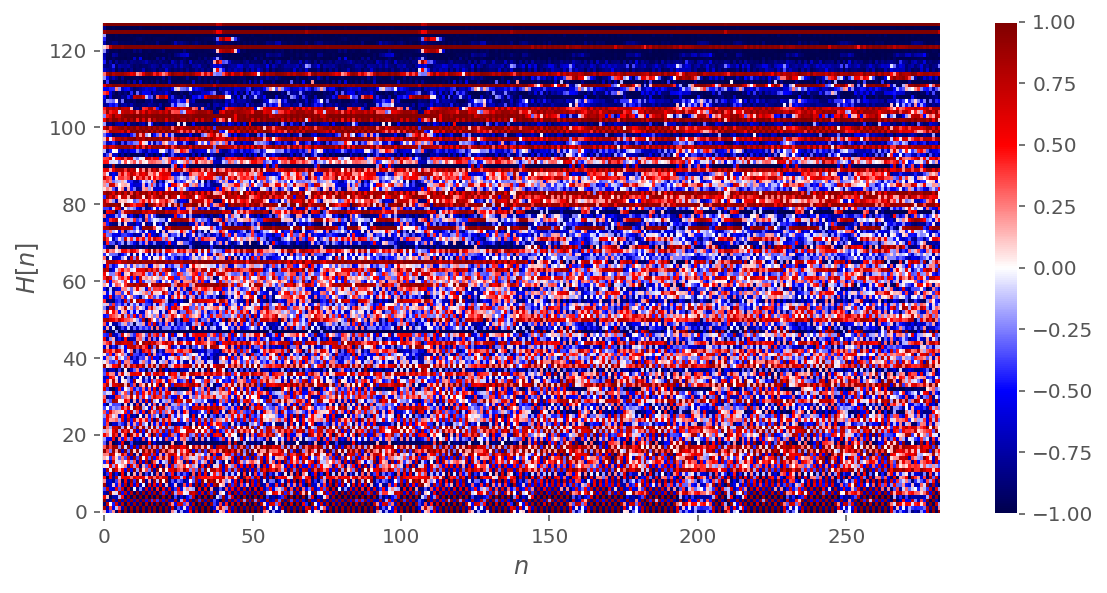

In [133]:
X_, Y_, Sg = GRUstatemodel.predict(X)
X_, Y_, Sr = RNNstatemodel.predict(X)

print('                           Fig. 3: GRU')
plotMelody(P, T, dictionaries=dictionaries, H=Sg[0], H_only=True)
print('                           Fig. 4: RNN')
plotMelody(P, T, dictionaries=dictionaries, H=Sr[0], H_only=True)

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.

**NB:** Absolute change in activation is averaged throughout a single sequence for a given unit, giving the number of instances _number of sequences in dataset x number of hidden units_ (see below).

In [90]:
len(np.array(RNNavg).flatten())/P_matrix.shape[0]
# 128 is the number of hidden units.

128.0

**Answer:**
**Figures 1-2** show the distinction between the properties of RNN vs GRU. For GRU, we observe that significantly more units remain relatively stable (close-to-zero avgs) comparing to RNN. And in general, avg update values are lower in GRU than in RNN, which means that GRU is more stable. This is because RNN doesn't have memory and 'jumps to conclusions' at each timestep, whereas GRU is designed to 'prefer' long-term dependencies to instant updates.

In the **figures 3-4**, which represent the hidden states, the same difference between RNN and GRU can be seen. RNN's units switch more sharply, producing distinct patterns, whereas the picture for GRUs is smoother through time. Also note that the hidden states patterns have two distinct modes in time, representing two frequency ranges in pitches that can be seen on the `plotMelody` figure in the very beginning of 6.2.

This memory retention property (that GRU posesses) is important for music, where the next note played may depend on the series of notes played much beforehand, as is the case with choruses, for example. Hence, the GRU model prefroms better.

TODO: On raster plot from min tanh to max tanh -> much more negative weights in GRU than RNN.
Also GRU more stable ?

## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [134]:
maxlen = 393
P_matrix = np.load('data/P_matrix.npy')
T_matrix = np.load('data/T_matrix.npy')
with open('data/dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)

In [135]:
def get_rand_note():
    """Generate a not with random pitch and duration
    and pad it to fit the model.
    """
    lenP = len(dictionaries['P'])
    P = np.zeros(lenP)
    P[np.random.choice(np.arange(lenP))] = 1

    lenT = len(dictionaries['T'])
    T = np.zeros(lenT)
    T[np.random.choice(np.arange(lenT))] = 1

    P = P[:, np.newaxis]
    T = T[:, np.newaxis]
    
    P_padded = pad_sequences(P, maxlen=maxlen-1, padding='post').T[np.newaxis]
    T_padded = pad_sequences(T, maxlen=maxlen-1, padding='post').T[np.newaxis]
    
    return T_padded, P_padded

**GRU**

In [136]:
GRUmodel = buildModel(dictionaries, 
                      batch_length=maxlen-1, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU')

with open('output/gru/weights_4.pkl', 'rb') as f:
    GRUmodel.set_weights(pickle.load(f))

In [137]:
note = get_rand_note()
melody = GRUmodel.predict([note[0], note[1]])

Melody with temperature: 0.5


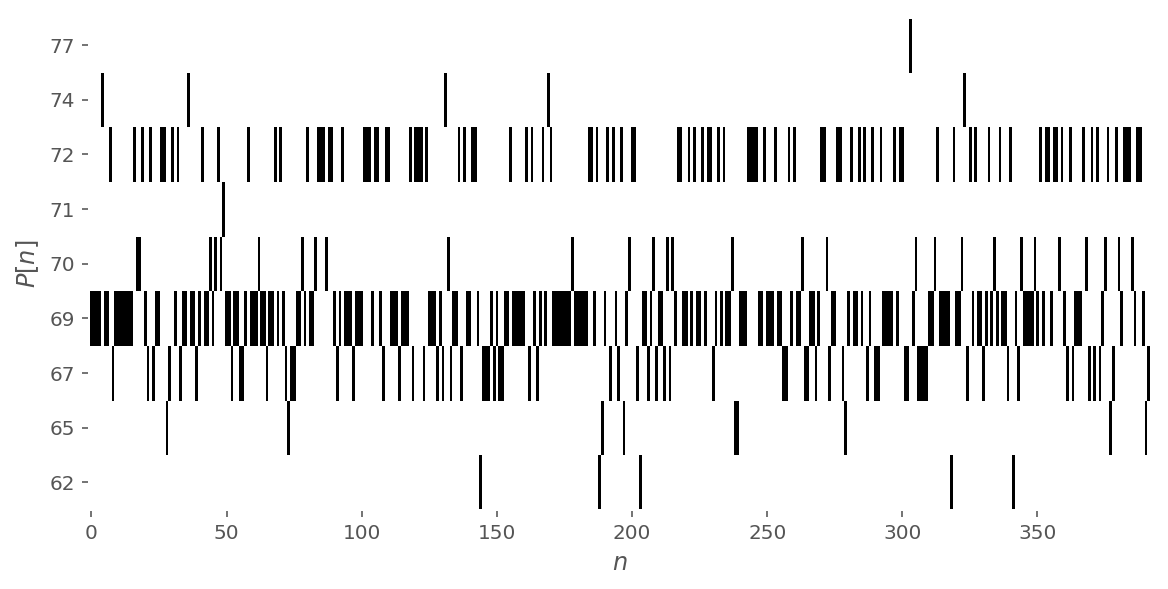

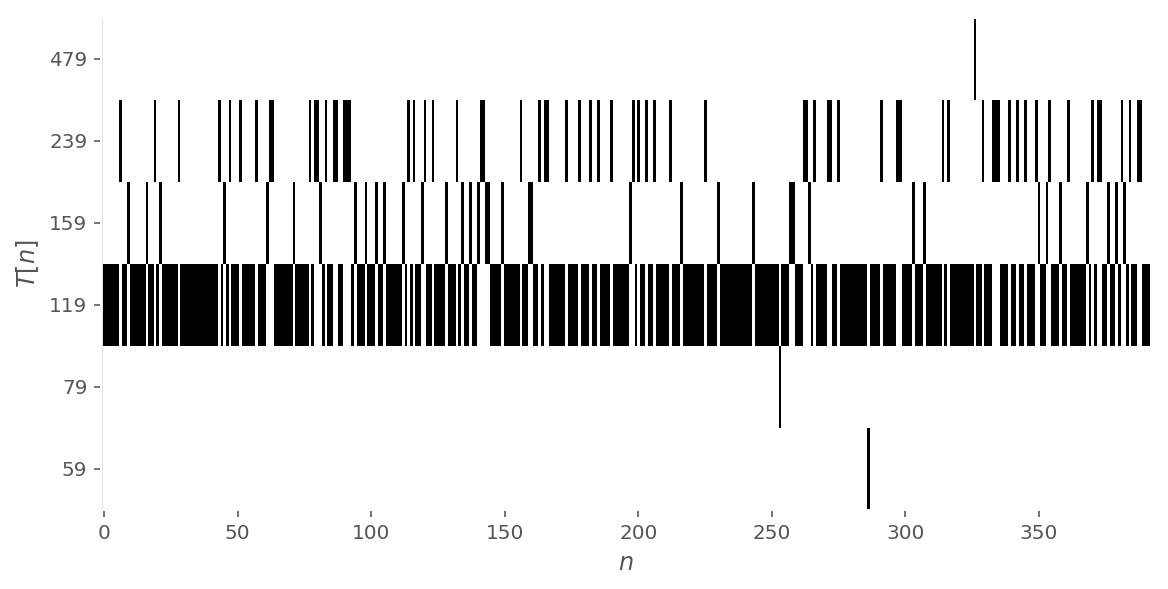

Melody with temperature: 1.0


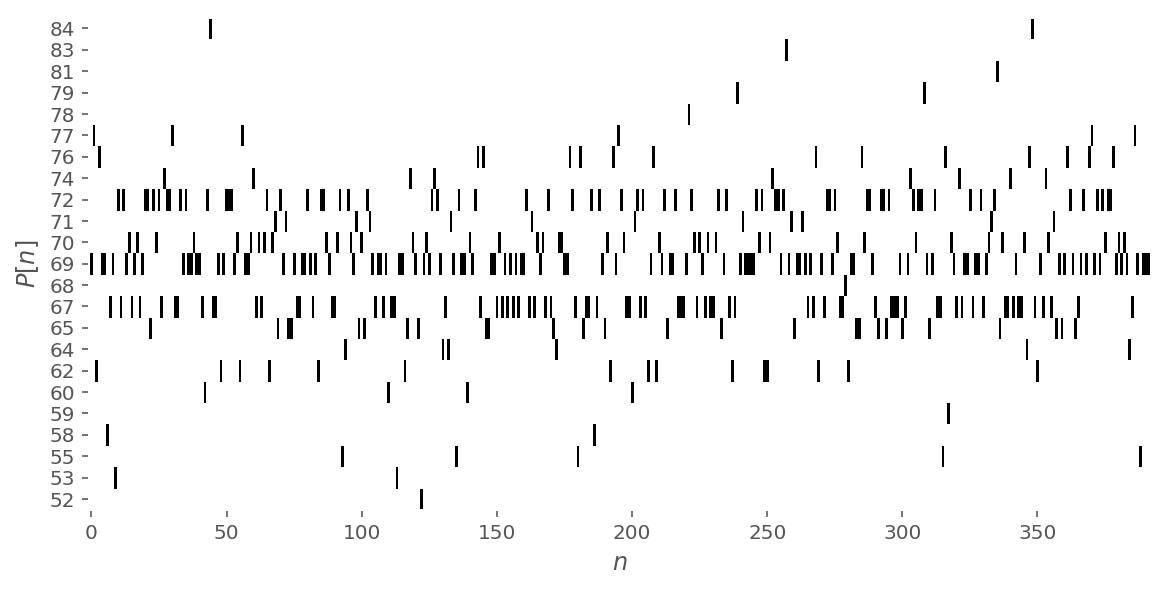

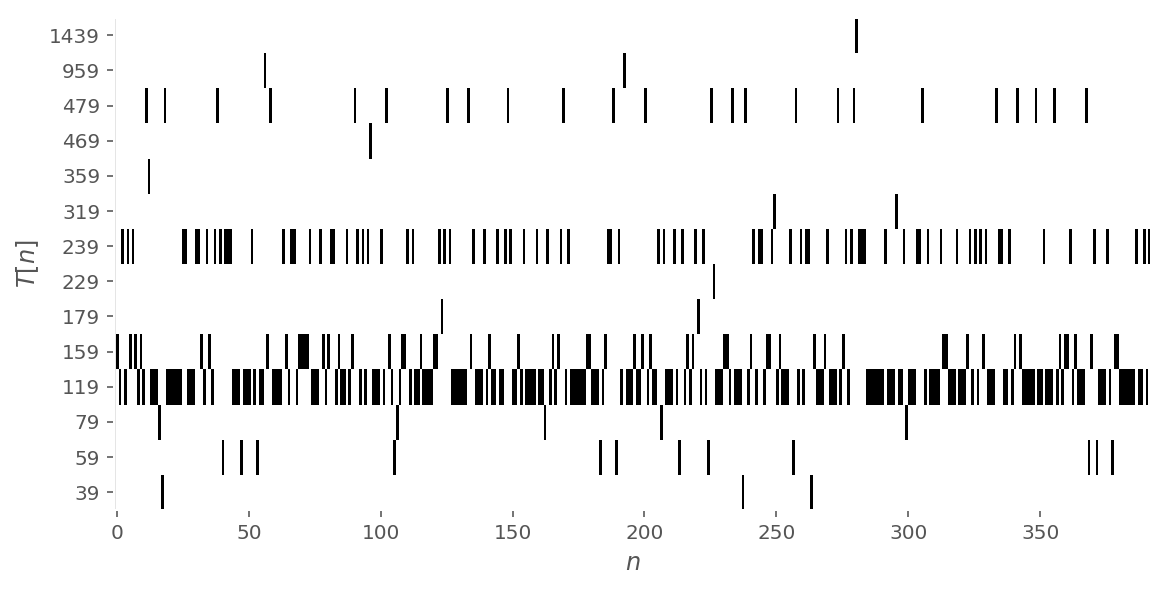

Melody with temperature: 1.5


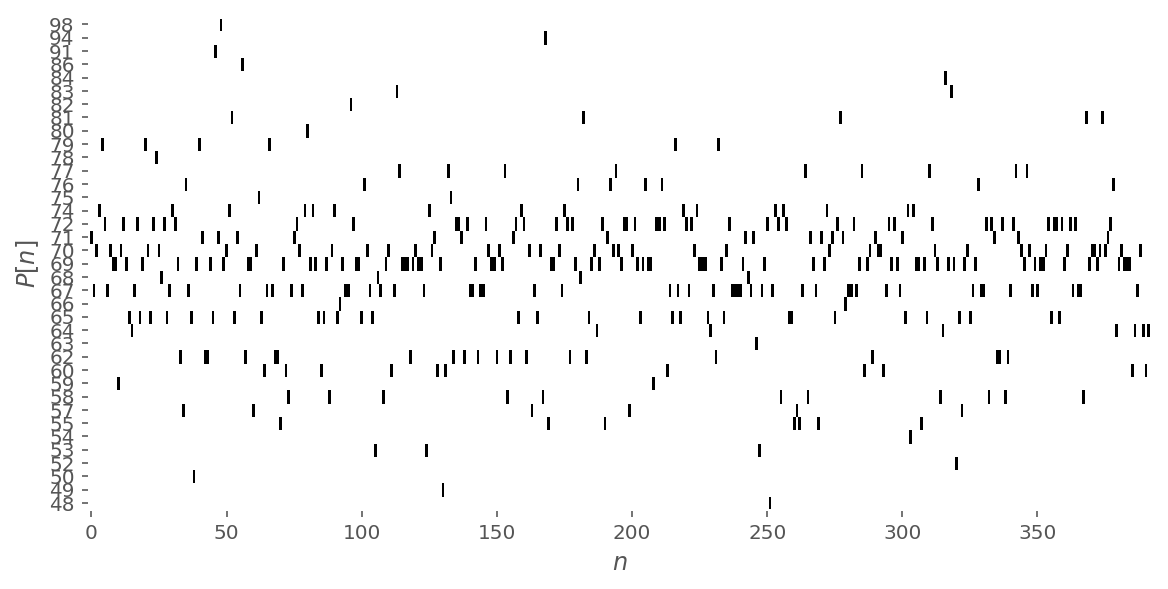

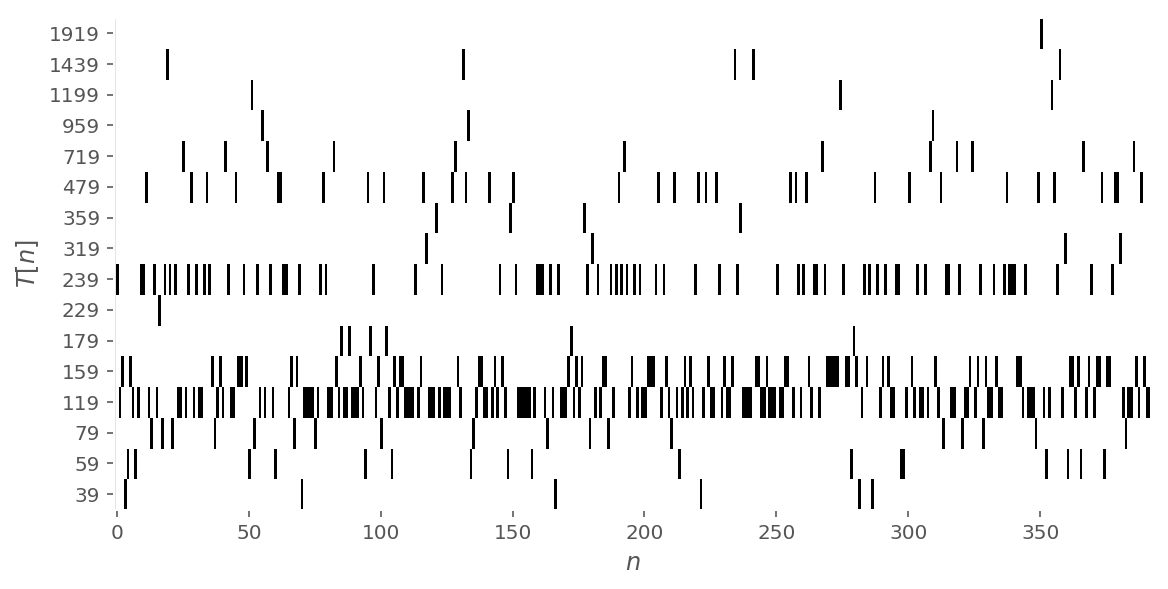

In [140]:
temperatures = [0.5, 1.0, 1.5]
for temperature in temperatures:
    xP = np.array(list(map(lambda x: sample(x, temperature=temperature), melody[1][0])))
    xT = np.array(list(map(lambda x: sample(x, temperature=temperature), melody[0][0])))
    print("Melody with temperature: " + str(temperature))
    plotMelody(xP, xT, dictionaries=dictionaries)
    writeMIDI(xP, xT, dictionaries, 'melodies/temp/GRU_{}.mid'.format(int(temperature*100)))

In [141]:
print('GRU')
music21.midi.translate.midiFilePathToStream('melodies/temp/GRU_50.mid').show('midi')

GRU


In [142]:
print('GRU')
music21.midi.translate.midiFilePathToStream('melodies/temp/GRU_100.mid').show('midi')

GRU


In [143]:
print('GRU')
music21.midi.translate.midiFilePathToStream('melodies/temp/GRU_150.mid').show('midi')

GRU


In [144]:
# Generate 32 random melodies.
for i in range(32):
    note = get_rand_note()
    melody = GRUmodel.predict([note[0], note[1]])
    xP = np.array(list(map(lambda x: sample(x), melody[1][0])))
    xT = np.array(list(map(lambda x: sample(x), melody[0][0])))
    writeMIDI(xP, xT, dictionaries, 'melodies/gru/GRU_{}.mid'.format(int(i)))

In [145]:
print('GRU')
for i in np.random.choice(np.arange(32), 4, replace=False):
    print('Melody No {}'.format(i))
    music21.midi.translate.midiFilePathToStream('melodies/gru/GRU_{}.mid'.format(i)).show('midi')

GRU
Melody No 2


Melody No 21


Melody No 16


Melody No 0


**RNN**

In [146]:
RNNmodel = buildModel(dictionaries, 
                      batch_length=maxlen-1,
                      activation='RNN')

with open('output/rnn/weights_4.pkl', 'rb') as f:
    RNNmodel.set_weights(pickle.load(f))

In [147]:
for i in range(32):
    note = get_rand_note()
    melody = GRUmodel.predict([note[0], note[1]])
    xP = np.array(list(map(lambda x: sample(x), melody[1][0])))
    xT = np.array(list(map(lambda x: sample(x), melody[0][0])))
    writeMIDI(xP, xT, dictionaries, 'melodies/rnn/RNN_{}.mid'.format(int(i)))

In [148]:
print('RNN')
for i in np.random.choice(np.arange(32), 4, replace=False):
    print('Melody No {}'.format(i))
    music21.midi.translate.midiFilePathToStream('melodies/rnn/RNN_{}.mid'.format(i)).show('midi')

RNN
Melody No 4


Melody No 29


Melody No 9


Melody No 7


**Question**: What is the effect of the sampling temperature on the generated melodies?

**Answer**: The higher the temperature ($t>1$) the more the variety and the less the harmonical correctness. The less the temperature ($0<t<1$), the less diverse the set of pitches and durations (as the sampling tends towards the values with higher probabilities) but more correct from the harmonical point of view.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: Yes, they are different. GRU's melodies sound more mature that RNN's ones, which are significantly more random. The melodies generated by the GRU model have a stronger tendency to maintain the same "theme" and "color" while the RNN model switches between themes/colors every 3 seconds or so.
